In [347]:
#imports 
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
    plot_global_confusion_matrix_sm2
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Detecting Pigs and Swedish Chef based on Audio Features
This notebook documents our approach to detect Pigs and the Swedish Chef based on audio feature-engineering.
Time Sheet for this Notebook:
Alina Ehart
todo


Loadting the data
Set the booleans below to extract the audio/frames from the .avi files if it has not been done previously.

In [237]:
#loading data
extract_audio = False
extract_frames = False

In [238]:
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)

Example for handling the data for video 0:

dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]

Audio Feature Extraction
Aligning audio features with video frame rate
The annotations are at the video frame level, for audio too. Therefore, we need to align the audio features with the video frames.

We start by checking the framerate of the videos and remind of our audio sampling rate:

In [4]:
%%sh

ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of default=noprint_wrappers=1:nokey=1 ../data/Muppets-02-01-01.avi


Couldn't find program: 'sh'


In [239]:
FRAMES_PER_SECOND = 25

In [240]:
AUDIO_SAMPLING_RATE = dataset.audios[0]["sr"]
AUDIO_SAMPLING_RATE

44100

There are 25 frames per second, and the 16k audio samples per second.
We therefore have 1764 audio samples per frame and divide our audio features in windows of 1764 samples.

Experimentation with Audio Features
As these featues were already used in the audio notebook for SM1, we did not further inspect or use them here.

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-01-01.wav'
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.title('Chroma Features')

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis='time')
plt.colorbar()
plt.title('Spectral Centroid')
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis='time')
plt.colorbar()
plt.title('Spectral Bandwidth')
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis='time')
plt.colorbar()
plt.title('Spectral Roll-off')
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()



KeyboardInterrupt: 

(12, 66659)
(7, 66659)
(1, 66659)
(1, 66659)
(1, 66659)
Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Bandwidth: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Roll-off: [[0. 0. 0. ... 0. 0. 0.]]


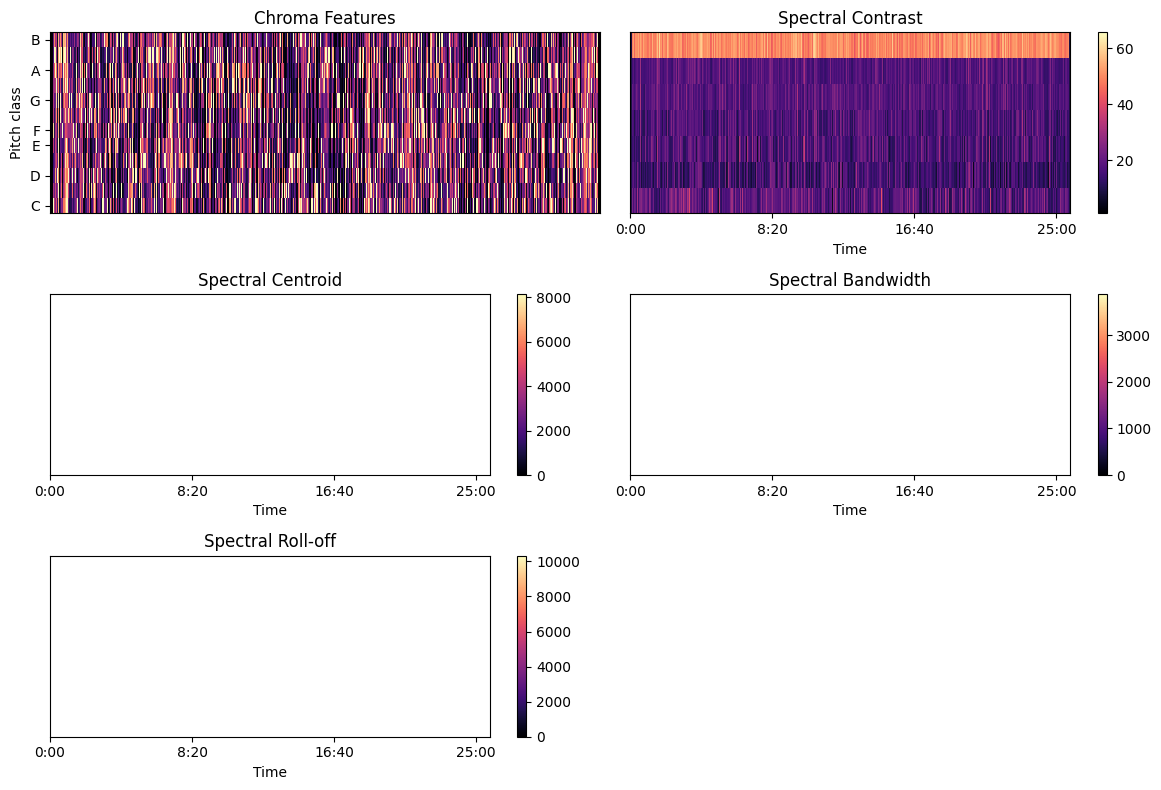

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-04-04.wav'
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.title('Chroma Features')

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis='time')
plt.colorbar()
plt.title('Spectral Centroid')
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis='time')
plt.colorbar()
plt.title('Spectral Bandwidth')
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis='time')
plt.colorbar()
plt.title('Spectral Roll-off')
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()


(12, 66299)
(7, 66299)
(1, 66299)
(1, 66299)
(1, 66299)
Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Bandwidth: [[0. 0. 0. ... 0. 0. 0.]]
Spectral Roll-off: [[0. 0. 0. ... 0. 0. 0.]]


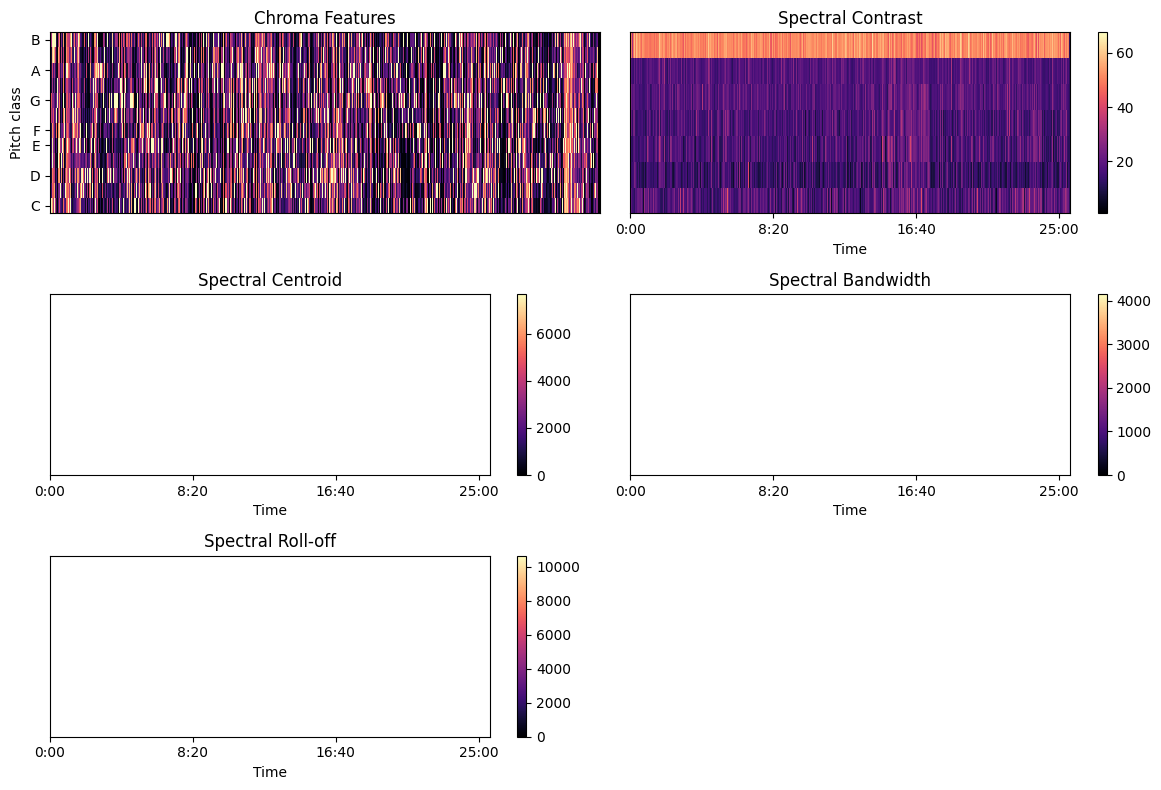

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '../data/audio/Muppets-03-04-03.wav'
y, sr = librosa.load(audio_file_path)

# Extract various timbre features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

print(chroma.shape)
print(contrast.shape)
print(centroid.shape)
print(bandwidth.shape)
print(rolloff.shape)

# Display the features
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
librosa.display.specshow(chroma, y_axis='chroma')
plt.title('Chroma Features')

plt.subplot(3, 2, 2)
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.title('Spectral Contrast')

plt.subplot(3, 2, 3)
librosa.display.specshow(centroid, x_axis='time')
plt.colorbar()
plt.title('Spectral Centroid')
print(f"Spectral Centroid: {centroid}")

plt.subplot(3, 2, 4)
librosa.display.specshow(bandwidth, x_axis='time')
plt.colorbar()
plt.title('Spectral Bandwidth')
print(f"Spectral Bandwidth: {bandwidth}")

plt.subplot(3, 2, 5)
librosa.display.specshow(rolloff, x_axis='time')
plt.colorbar()
plt.title('Spectral Roll-off')
print(f"Spectral Roll-off: {rolloff}")

plt.tight_layout()
plt.show()


STFT
in sm1 we have used the following timbre features
    loudness rms
    zcr
    mfccs
this leaves us free to use the following timbre features for SM2:
    spectral flatness
    tonnetz
    mel centroid
    sharpness
additionally, we compute the fourier tempogram 

For this audio approach, we do not want to operate on the audio files in their basic-from but employ STFT and extract timbre features on its basis. STFT provides a time-frequency representation of an audio signal, breaking it down into short time segments and revealing the frequency content within each segment. Timbre is closely related to spectral characteristics of sound, including the distribution of energy across different frequency bands. By analyzing the STFT, information about the frequency content at different points in time allows for detailed examiniation of spectral features. This aids distinguishing speech and singing patterns. - todo further details, each feature explainen


C:\Users\alina\AppData\Local\Temp\ipykernel_9752\3462702618.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


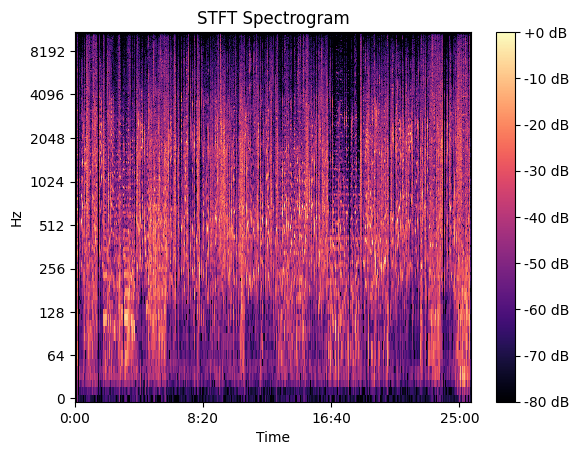

Zero Crossings: [[0.         0.         0.         ... 0.03613281 0.02832031 0.02099609]]
RMS Energy: [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.6840710e-05 1.4777792e-05
 1.2237879e-05]
Harmonic-to-Noise Ratio (HNR): [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.7491660e-05
 -1.5464770e-05 -1.1675758e-05]
Spectral Flatness: [[1.0000007  1.0000007  1.0000007  ... 0.05722385 0.06692996 0.09460584]]
Tonnetz: [[ 0.          0.          0.         ... -0.01516161  0.01703167
   0.01122424]
 [ 0.          0.          0.         ... -0.05483576 -0.05206411
  -0.02138115]
 [ 0.          0.          0.         ... -0.04859439 -0.04497281
  -0.03998579]
 [ 0.          0.          0.         ... -0.03672028 -0.03056692
  -0.00499801]
 [ 0.          0.          0.         ...  0.01351141  0.00037324
  -0.00739452]
 [ 0.          0.          0.         ... -0.00776486 -0.00810733
  -0.00215161]]
Mel-frequency Spectral Centroid: [[   0.            0.            0.         ... 4689.9317

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-01-01.wav'
y, sr = librosa.load(audio_file_path)

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Display the STFT spectrogram
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('STFT Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()
# Feature extraction
#zero_crossings = librosa.feature.zero_crossing_rate(y)
#rms = librosa.feature.rms(y=y)[0]  # Compute RMS energy
#hnr = librosa.effects.harmonic(y)
spectral_flatness = librosa.feature.spectral_flatness(y=y)
# Check if pitches and magnitudes are not empty before accessing the maximum value
hop_length = 512  # You can adjust this value based on your needs
n_fft = 2048  # You can adjust this value based on your needs
center = True  # You can set it to False if needed

tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
mel_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center)
sharpness = -librosa.feature.delta(spectral_flatness)

# Display or use the extracted features

#print("Harmonic-to-Noise Ratio (HNR):", hnr)
print("Spectral Flatness:", spectral_flatness)
print("Tonnetz:", tonnetz)
print("Mel-frequency Spectral Centroid:", mel_centroid)
print("Perceptual Sharpness:", sharpness)

C:\Users\alina\AppData\Local\Temp\ipykernel_9752\791250290.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


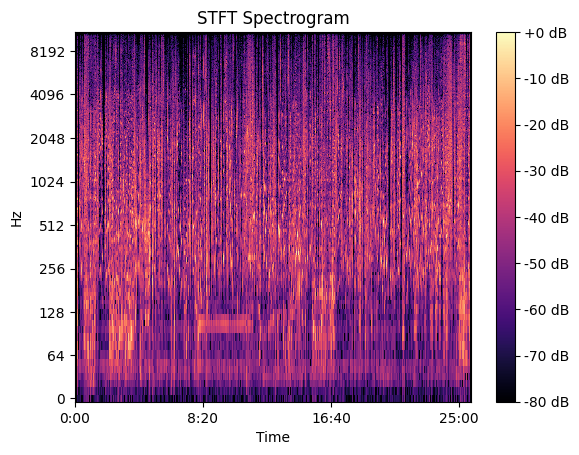

Harmonic-to-Noise Ratio (HNR): [0. 0. 0. ... 0. 0. 0.]
Tonnetz: [[ 0.          0.          0.         ...  0.0448432   0.00675244
   0.01239564]
 [ 0.          0.          0.         ...  0.1414606   0.08569031
   0.02552758]
 [ 0.          0.          0.         ...  0.04957253 -0.00952875
  -0.0147702 ]
 [ 0.          0.          0.         ... -0.02695864  0.01168429
   0.00547853]
 [ 0.          0.          0.         ...  0.08416764  0.01424239
  -0.01793548]
 [ 0.          0.          0.         ... -0.01636204  0.01703281
   0.04656267]]
Mel-frequency Spectral Centroid: [[0. 0. 0. ... 0. 0. 0.]]
Perceptual Sharpness: [[-3.7717355e-17 -3.7717355e-17 -3.7717355e-17 ... -3.7717355e-17
  -3.7717355e-17 -3.7717355e-17]]
Spectral Flatness:  [[1.0000007 1.0000007 1.0000007 ... 1.0000007 1.0000007 1.0000007]]


In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
audio_file_path = '../data/audio/Muppets-02-04-04.wav'
y, sr = librosa.load(audio_file_path)

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Display the STFT spectrogram
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('STFT Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Feature extraction

# Calculate harmonic component from the STFT
y_harmonic, y_percussive = librosa.effects.hpss(y)
hnr = librosa.effects.harmonic(y_harmonic)

# Calculate tonnetz based on the harmonic component from the STFT
tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)

# Check if pitches and magnitudes are not empty before accessing the maximum value
hop_length = 512  # You can adjust this value based on your needs
n_fft = 2048  # You can adjust this value based on your needs
center = True  # You can set it to False if needed

# Calculate mel-frequency spectral centroid
mel_centroid = librosa.feature.spectral_centroid(S=np.abs(D)**2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center)

# Calculate sharpness
spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D)**2)
sharpness = -librosa.feature.delta(spectral_flatness)

# Display or use the extracted features

print("Harmonic-to-Noise Ratio (HNR):", hnr)
print("Tonnetz:", tonnetz)
print("Mel-frequency Spectral Centroid:", mel_centroid)
print("Perceptual Sharpness:", sharpness)
print("Spectral Flatness: ",spectral_flatness)


Audio Feature Extraction & Annotation

In [7]:
#padding of last 8s silence
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1

    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )

In [17]:
for audio in dataset.audios:
    y= audio["audio"]
    #Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length =  int(audio["sr"] / FRAMES_PER_SECOND)  # You can adjust this value based on your needs
    n_fft =  2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    win_length = int(audio["sr"] / FRAMES_PER_SECOND)
    sr = FRAMES_PER_SECOND
    D=librosa.stft(y, hop_length=hop_length, win_length=win_length)

    # Calculate harmonic component from the STFT
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    
    #HNR
    #hnr = librosa.effects.harmonic(y_harmonic)

    #Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    #chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length=hop_length)
    # Check the data type of y
    if D.dtype != np.float32 and D.dtype != np.float64:
    # If not floating-point, convert to float32
        D = D.astype(np.float32)
    #tonnetz = librosa.feature.tonnetz(y=y, sr = FRAMES_PER_SECOND,chroma=None,hop_length=hop_length)
    #Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(S=np.abs(D)**2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center,win_length=win_length)
    #spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D)**2,win_length=win_length, hop_length=hop_length)

    #perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)
    # audio["tonnetz_0"]=tonnetz[0]
    # audio["tonnetz_1"]=tonnetz[1]
    # audio["tonnetz_2"]=tonnetz[2] 
    # audio["tonnetz_3"]=tonnetz[3]
    # audio["tonnetz_4"]=tonnetz[4]
    # audio["tonnetz_5"]=tonnetz[5]
    audio["mel_centroid"]=mel_centroid
    audio["sharpness"]=sharpness

C:\Users\alina\AppData\Local\Temp\ipykernel_19616\602545356.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  D = D.astype(np.float32)


tried to compute tonnetz and chormagram as well, but it did not work; Always throwing a parameter error like this: ParameterError: Wavelet basis with max frequency=3951.066410048993 would exceed the Nyquist frequency=12.5. Try reducing the number of frequency bins.
We suppose it just does not work on our audio size with the given sample rate. We continued to train our model with the mel_centroid 

In [19]:
#merging into dataset
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    "sharpness":np.ravel(audio["sharpness"]),
                    "mel_centroid": np.ravel(audio["mel_centroid"])
                }
            ),
        ],
        ignore_index=True,
    )
    #add annotations
    audio_features = audio_features.merge(
    dataset.annotations[["Video", "Frame_number", "Audio_Pigs","Audio_MissPiggy" ,"Audio_Cook"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
audio_features = audio_features.drop(columns=["Frame_number", "Video"])

In [21]:
assert dataset.annotations.shape[0] == audio_features.shape[0]
assert dataset.annotations["Audio_Cook"].sum() == audio_features["Audio_Cook"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Audio_Cook"].values, audio_features["Audio_Cook"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_Pigs"].values,
    audio_features["Audio_Pigs"].values,
)#
np.testing.assert_array_equal(
    dataset.annotations["Audio_MissPiggy"].values,
    audio_features["Audio_MissPiggy"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    audio_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    audio_features["frame_idx"].values,
)

In [23]:
audio_features.sample(10)
audio_features.drop(columns=["Video_x","Frame_number_x","Audio_Pigs_x","Audio_MissPiggy_x","Audio_Cook_x",
                             "Video_y","Frame_number_y","Audio_Pigs_y","Audio_MissPiggy_y","Audio_Cook_y" ])

,video_idx,frame_idx,sharpness,mel_centroid,Audio_Pigs,Audio_MissPiggy,Audio_Cook
0,0,0,-3.771735e-17,0.0,0,0,0
1,0,1,-3.771735e-17,0.0,0,0,0
2,0,2,-3.771735e-17,0.0,0,0,0
3,0,3,-3.771735e-17,0.0,0,0,0
4,0,4,3.469449e-18,0.0,0,0,0
...,...,...,...,...,...,...,...
115880,2,38493,3.469449e-18,0.0,0,0,0
115881,2,38494,-3.771735e-17,0.0,0,0,0
115882,2,38495,-3.771735e-17,0.0,0,0,0
115883,2,38496,-3.771735e-17,0.0,0,0,0


In [30]:
#X,y split
X = audio_features.drop(
    columns=["Audio_MissPiggy","Audio_Pigs","Audio_Cook","video_idx","frame_idx"]
)
X.sample()
y = audio_features[["Audio_MissPiggy","Audio_Pigs","Audio_Cook"]]


In [25]:
RANDOM_SPLIT = True

In [39]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [42]:
#X_train.drop(columns=["Video_x","Frame_number_x","Audio_Pigs_x","Audio_MissPiggy_x","Audio_Cook_x","Video_y","Frame_number_y","Audio_Pigs_y","Audio_MissPiggy_y","Audio_Cook_y"],inplace=True)
#X_train.sample()
#X_test.drop(columns=["Video_x","Frame_number_x","Audio_Pigs_x","Audio_MissPiggy_x","Audio_Cook_x","Video_y","Frame_number_y","Audio_Pigs_y","Audio_MissPiggy_y","Audio_Cook_y"],inplace=True)
X_test.sample()

,sharpness,mel_centroid
52014,8.124479e-08,0.6036


In [43]:
#pigs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
max_iter=100
rc_pigs = RidgeClassifier()
rc_pigs.fit(X_train,y_train["Audio_Pigs"])

if rc_pigs.n_iter_ == max_iter:
    print("Solver has reached the maximum number of iterations. Consider increasing max_iter.")
else:
    print("Solver has converged within the specified max_iter.")

y_pred_pigs = rc_pigs.predict(X_test)

Solver has converged within the specified max_iter.


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_Pigs Predominant Color only: 
Accuracy: 0.9453337360314105
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[21910     0]
 [ 1267     0]]


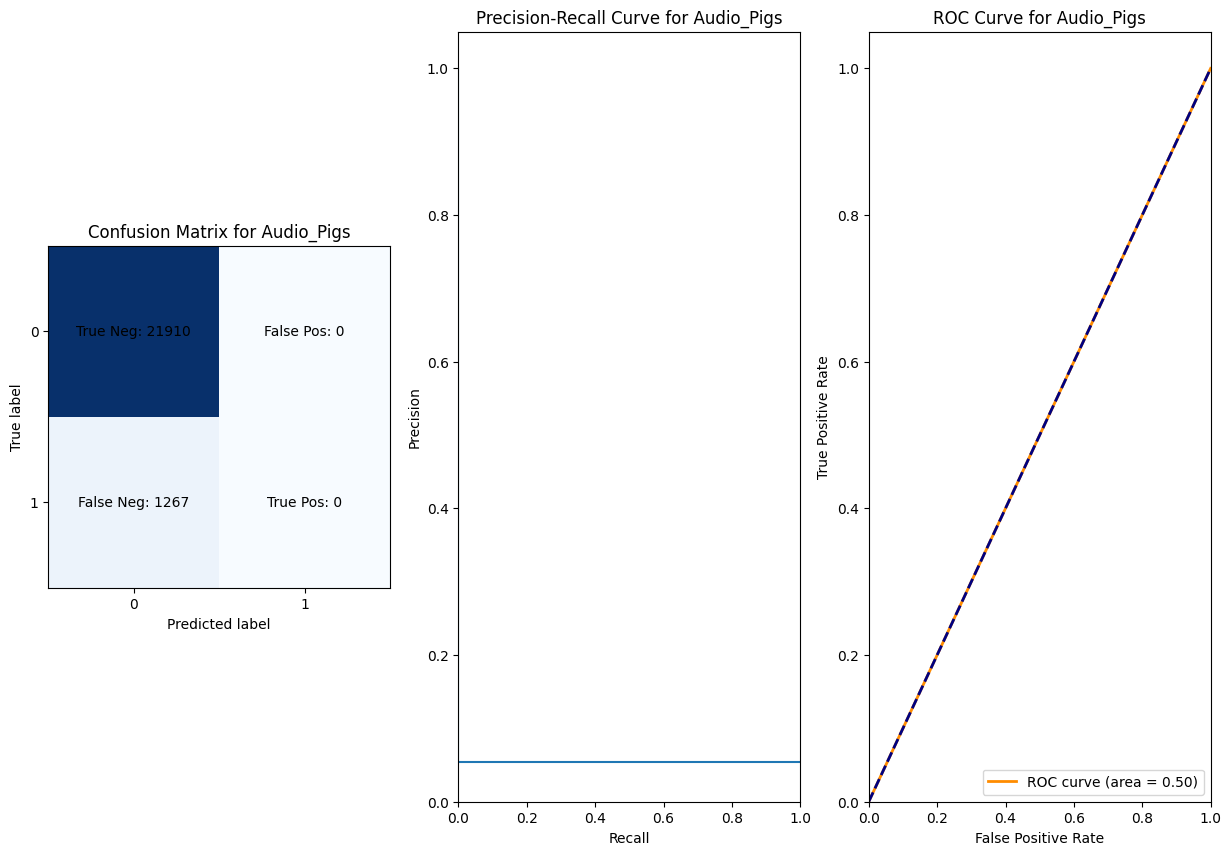

In [44]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [45]:
#miss piggy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
max_iter=100
rc_mp = RidgeClassifier()
rc_mp.fit(X_train,y_train["Audio_MissPiggy"])

if rc_mp.n_iter_ == max_iter:
    print("Solver has reached the maximum number of iterations. Consider increasing max_iter.")
else:
    print("Solver has converged within the specified max_iter.")

y_pred_mp = rc_mp.predict(X_test)

Solver has converged within the specified max_iter.


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_MissPiggy Predominant Color only: 
Accuracy: 0.9630668334987272
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[22321     0]
 [  856     0]]


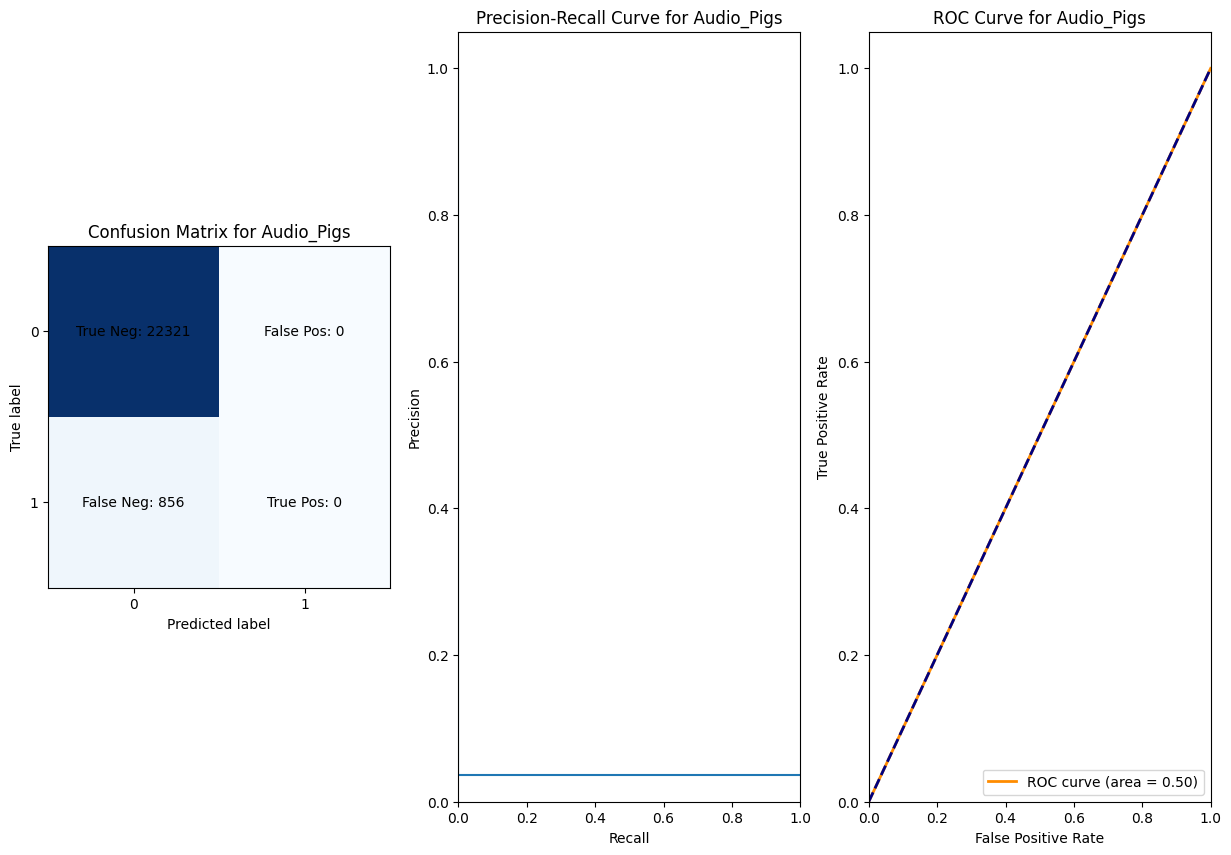

In [46]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Audio_Pigs", ax=axs[2])

In [47]:
#cook
#miss piggy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
max_iter=100
rc_cook = RidgeClassifier()
rc_cook.fit(X_train,y_train["Audio_Cook"])

if rc_cook.n_iter_ == max_iter:
    print("Solver has reached the maximum number of iterations. Consider increasing max_iter.")
else:
    print("Solver has converged within the specified max_iter.")

y_pred_cook = rc_cook.predict(X_test)

Solver has converged within the specified max_iter.


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_Cook Predominant Color only: 
Accuracy: 0.9861500625620226
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[22856     0]
 [  321     0]]


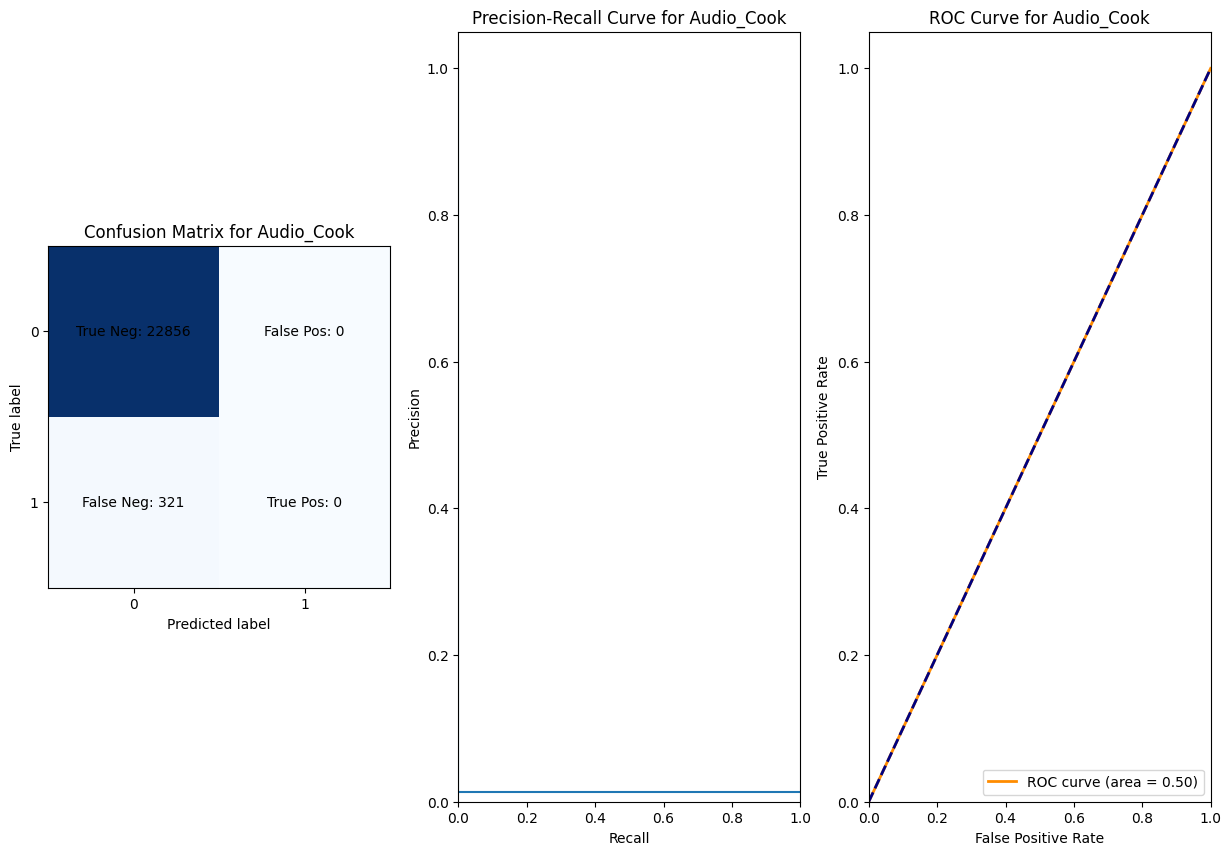

In [48]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"],y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"], y_pred_cook, "Precision-Recall Curve for Audio_Cook", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

In [19]:
import scipy.stats

for audio in dataset.audios:
    y= audio["audio"]
    #Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length =  int(audio["sr"] / FRAMES_PER_SECOND)  # You can adjust this value based on your needs
    n_fft =  2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    win_length = int(audio["sr"] / FRAMES_PER_SECOND)
    sr = FRAMES_PER_SECOND
    D=librosa.stft(y, hop_length=hop_length, win_length=win_length)

    # Calculate harmonic component from the STFT
    y_harmonic, y_percussive = librosa.effects.hpss(y)

    
    #HNR
    hnr = librosa.effects.harmonic(y_harmonic)

    #Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    #chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length=hop_length)
    # Check the data type of y
    # if D.dtype != np.float32 and D.dtype != np.float64:
    # # If not floating-point, convert to float32
    #     D = D.astype(np.float32)
    #tonnetz = librosa.feature.tonnetz(y=y, sr = FRAMES_PER_SECOND,chroma=None)
    #Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(S=np.abs(D)**2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center,win_length=win_length)
    #spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D)**2,win_length=win_length, hop_length=hop_length)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr, onset_envelope=onset_env, hop_length=hop_length, win_length=win_length)
    dtempo = librosa.feature.tempo(y=y, tg=tempogram,sr=sr,hop_length=hop_length,
                               aggregate=None)
    poly_features = librosa.feature.poly_features(y=y,sr=sr, hop_length=hop_length, win_length=win_length)
    ft_tempogram = librosa.feature.fourier_tempogram(y=y,sr=sr, hop_length=hop_length,win_length=win_length)
    ac_tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr,hop_length=hop_length, win_length=win_length, norm=None)


    onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    magnitude,phase = librosa.magphase(D)
    skewness  = scipy.stats.skew(magnitude,axis=1)
    kurtosis =scipy.stats.kurtosis(magnitude,axis=1)
    
    audio["dtempo"]=dtempo
    audio["poly_features"]=poly_features
    audio["ac_ft_tempogram"]=ac_tempogram
    audio["onset_strength"]=onset_strength
    audio["onset_env"]=onset_env
    audio["skewness"]=skewness
    audio["kurtosis"]=kurtosis
    #audio["cqt"]=cqt



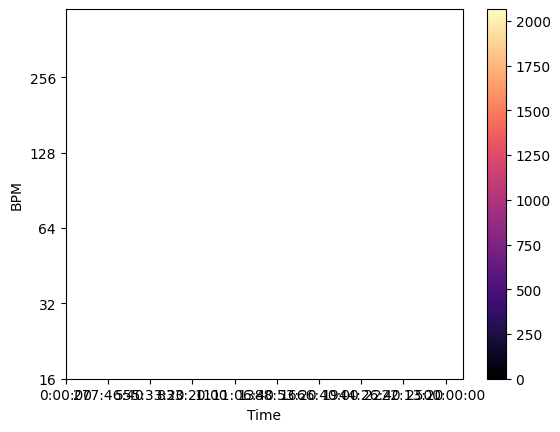

In [24]:
librosa.display.specshow(dataset.audios[0]["ac_ft_tempogram"], sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.show()

In [20]:
print(dataset.audios[0]["dtempo"].shape)
print(dataset.audios[0]["poly_features"].shape)
print(dataset.audios[0]["ac_ft_tempogram"].shape)
print(dataset.audios[0]["onset_strength"].shape)
print(dataset.audios[1]["onset_env"].shape)
print(dataset.audios[1]["onset_env"])
print(dataset.audios[0]["skewness"].shape)
print(dataset.audios[0]["kurtosis"].shape)


(133265,)
(2, 38681)
(1764, 133265)
(133265,)
(133351,)
[0. 0. 0. ... 0. 0. 0.]
(1025,)
(1025,)


In [8]:
for audio in dataset.audios:
    y= audio["audio"]
    #Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length =  int(audio["sr"] / FRAMES_PER_SECOND)  # You can adjust this value based on your needs
    n_fft =  2048  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    win_length = int(audio["sr"] / FRAMES_PER_SECOND)
    sr = FRAMES_PER_SECOND
    D=librosa.stft(y, hop_length=hop_length, win_length=win_length)

    # Calculate harmonic component from the STFT
    #y_harmonic, y_percussive = librosa.effects.hpss(y)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr,win_length=win_length, hop_length=hop_length)
    print(win_length)
    tempo, beats = librosa.beat.beat_track(y=y,onset_envelope=onset_env,units='frames',hop_length=hop_length,
                                       sr=sr)
   # onset_env = librosa.onset.onset_strength(y=y, sr=sr)
   # tempogram = librosa.feature.tempogram(y=y, sr=sr, onset_envelope=onset_env, hop_length=hop_length, win_length=win_length)
    #dtempo = librosa.feature.tempo(y=y, tp = tempogram,onset_envelope=onset_env,sr=sr, aggregate=None)
   # tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,
                                      # sr=sr)
    #poly_features = librosa.feature.poly_features(y=y,sr=sr, hop_length=hop_length, win_length=win_length)
    #ft_tempogram = librosa.feature.fourier_tempogram(y=y,sr=sr, hop_length=hop_length,win_length=win_length)
    #ac_tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr,hop_length=hop_length, win_length=win_length, norm=None)


    #onset_strength = librosa.onset.onset_strength(y=y, sr=sr)
    #magnitude,phase = librosa.magphase(D)
    #skewness  = scipy.stats.skew(magnitude,axis=1)
    #kurtosis =scipy.stats.kurtosis(magnitude,axis=1)
    audio["beats"]=beats
    print(beats.shape)
   # audio["dtempo"]=dtempo
   # audio["poly_features"]=poly_features
    #audio["ac_ft_tempogram"]=ac_tempogram
   # audio["onset_strength"]=onset_strength
   # audio["onset_env"]=onset_env
   # audio["skewness"]=skewness
  #  audio["kurtosis"]=kurtosis
    #audio["cqt"]=cqt


1764


ParameterError: win_length must be a positive integer

In [14]:
#merging into dataset
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                    #"dtempo":audio["dtempo"],
                    "poly_features_1": audio["poly_features"][0],
                    "poly_features_2": audio["poly_features"][1]
                }
            ),
        ],
        ignore_index=True,
    )
    #add annotations
    audio_features = audio_features.merge(
    dataset.annotations[["Video", "Frame_number", "Audio_Pigs","Audio_MissPiggy" ,"Audio_Cook"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
audio_features = audio_features.drop(columns=["Frame_number", "Video"])

In [15]:
audio_features.sample(10)

,video_idx,frame_idx,poly_features_1,poly_features_2,Video_x,Frame_number_x,Audio_Pigs_x,Audio_MissPiggy_x,Audio_Cook_x,Video_y,Frame_number_y,Audio_Pigs_y,Audio_MissPiggy_y,Audio_Cook_y,Audio_Pigs,Audio_MissPiggy,Audio_Cook
52173,1,13492,-0.017835,0.160929,NaN,NaN,NaN,NaN,NaN,1.0,13492.0,0.0,0.0,0.0,0,0,0
1878,0,1878,-0.019656,0.177917,0.0,1878.0,0.0,0.0,0.0,0.0,1878.0,0.0,0.0,0.0,0,0,0
110127,2,32740,-0.015174,0.132497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
36003,0,36003,-0.072232,0.636257,0.0,36003.0,0.0,0.0,0.0,0.0,36003.0,0.0,0.0,0.0,0,0,0
58854,1,20173,-0.015808,0.136227,NaN,NaN,NaN,NaN,NaN,1.0,20173.0,1.0,1.0,0.0,1,1,0
78410,2,1023,-0.148354,1.284629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
38881,1,200,-0.103735,0.934221,NaN,NaN,NaN,NaN,NaN,1.0,200.0,0.0,0.0,0.0,0,0,0
45086,1,6405,-0.046736,0.423450,NaN,NaN,NaN,NaN,NaN,1.0,6405.0,0.0,0.0,0.0,0,0,0
111122,2,33735,-0.048564,0.425281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
90069,2,12682,-0.066449,0.588277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [17]:
#X,y split
# X = audio_features.drop(
#     columns=["Audio_MissPiggy","Audio_Pigs","Audio_Cook","video_idx","frame_idx"]
# )
X.sample()
y = audio_features[["Audio_MissPiggy","Audio_Pigs","Audio_Cook"]]
X=audio_features[["poly_features_1", "poly_features_2"]]

In [18]:
RANDOM_SPLIT = True
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [19]:
#pigs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
max_iter=100
rc_pigs = RidgeClassifier()
rc_pigs.fit(X_train,y_train["Audio_Pigs"])

if rc_pigs.n_iter_ == max_iter:
    print("Solver has reached the maximum number of iterations. Consider increasing max_iter.")
else:
    print("Solver has converged within the specified max_iter.")

y_pred_pigs = rc_pigs.predict(X_test)

Solver has converged within the specified max_iter.


In [21]:
#sus wie schnell das geht... probiere mit svm
# training model for Kermit
from sklearn.svm import SVC

svm_pigs=SVC()

svm_pigs.fit(X_train, y_train["Audio_Pigs"])

y_pred_pigs = svm_pigs.predict(X_test)


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for Audio_Pigs Predominant Color only: 
Accuracy: 0.9453337360314105
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[21910     0]
 [ 1267     0]]


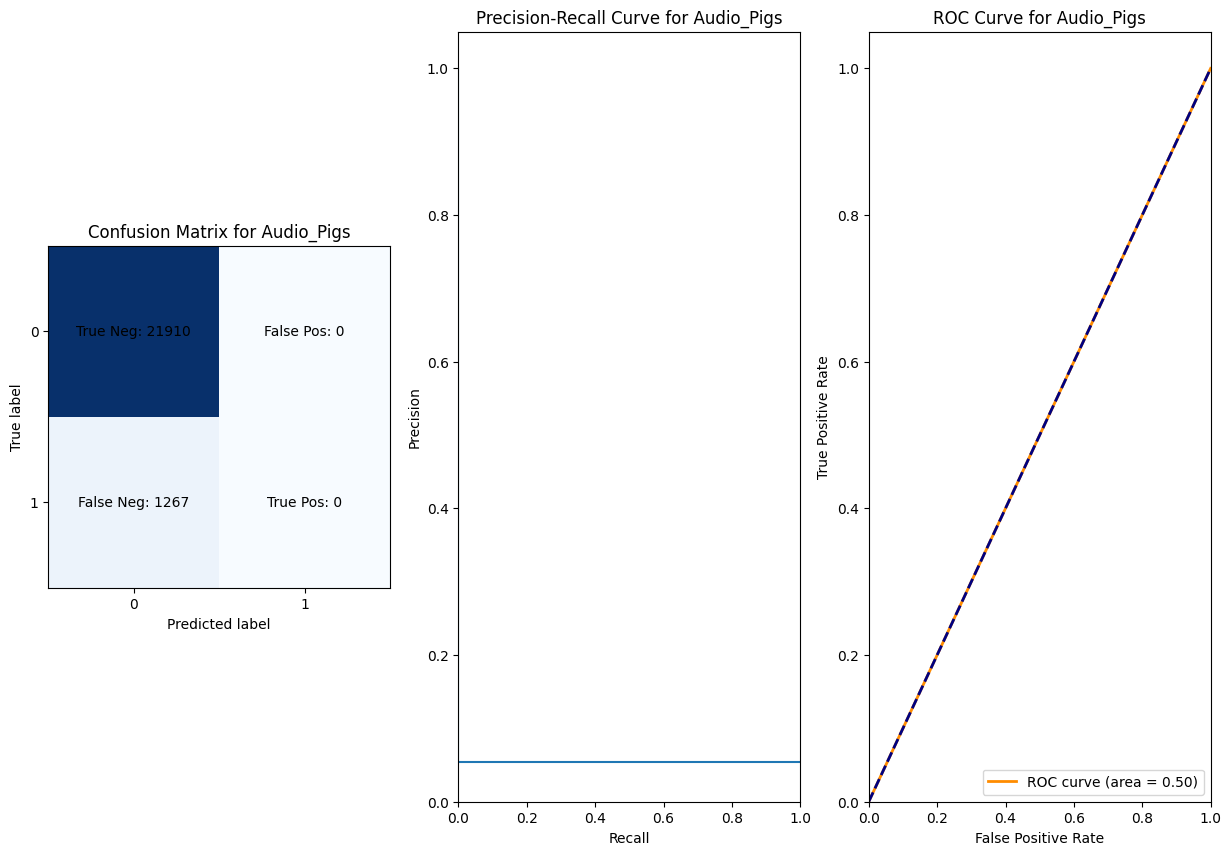

In [22]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [10]:
#not used
from sklearn.preprocessing import normalize
sr = FRAMES_PER_SECOND
#audio feature extraction
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1
    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
    
    
    audio["mel_centroid"] = mel_centroid
    audio["sharpness"]=sharpness
    audio["spectral_flatness"]=spectral_flatness
    #audio["ft_tempogram"] = ft_tempogram

AttributeError: No librosa attribute onset_strength

In [12]:
from sklearn.preprocessing import normalize
sr=25
#audio feature extractison
for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1
    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
    y=audio["audio"]
    #applying STFT
    D=librosa.stft(y)
    
    # Calculate harmonic component from the STFT
    #y_harmonic, y_percussive = librosa.effects.hpss(y)
    y_harmonic, sr = load_audio_frame(idx)
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, fmin=librosa.note_to_hz('C1'))
    tonnetz = librosa.feature.tonnetz(chroma=chromagram)

    # Check if pitches and magnitudes are not empty before accessing the maximum value
    hop_length = int(audio["sr"]/25)  # You can adjust this value based on your needs
    n_fft = int(audio["sr"]/25)  # You can adjust this value based on your needs
    center = True  # You can set it to False if needed
    #HNR
    #hnr = librosa.effects.harmonic(y_harmonic) #way too many features, cannot use

    #Tonnetz
    # Calculate tonnetz based on the harmonic component from the STFT
    #tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
# Calculate chromagram using chroma_cqt
   # Calculate chromagram using chroma_cqt with reduced fmin
    chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=FRAMES_PER_SECOND, fmin=librosa.note_to_hz('C1'))

# Calculate tonnetz based on the computed chromagram
    tonnetz = librosa.feature.tonnetz(chroma=chromagram)


    #Mel centroid
    mel_centroid = librosa.feature.spectral_centroid(S=np.abs(D)**2, sr=sr, hop_length=hop_length, n_fft=n_fft, center=center)
    #spectral flatness
    spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(D)**2)

    #perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)

    #ft tempgram
    #oenv = librosa.onset_strength(y=y,sr=sr, hop_length = hop_length )
    #ft_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,
#                                              hop_length=hop_length)
    #normalize
    #hnr =normalize(np.reshape(hnr, (1, -1)))
    tonnetz = normalize(tonnetz)
    mel_centroid = normalize(mel_centroid)
    sharpness = normalize(sharpness)
    spectral_flatness = normalize(spectral_flatness)

    #set features
    #audio["hnr"] = hnr
    audio["tonnetz"]=tonnetz
    audio["mel_centroid"] = mel_centroid
    audio["sharpness"]=sharpness
    audio["spectral_flatness"]=spectral_flatness
    #audio["ft_tempogram"] = ft_tempogram

c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


ParameterError: Wavelet basis with max frequency=4106.18221930793 would exceed the Nyquist frequency=12.5. Try reducing the number of frequency bins.

In [17]:
print(dataset.audios[0]["tonnetz"].shape)
print(dataset.audios[0]["hnr"].shape)
print(dataset.audios[0]["mel_centroid"].shape)
print(dataset.audios[0]["sharpness"].shape)
print(dataset.audios[0]["spectral_flatness"].shape)

print(dataset.audios[1]["tonnetz"].shape)
print(dataset.audios[1]["hnr"].shape)
print(dataset.audios[1]["mel_centroid"].shape)
print(dataset.audios[1]["sharpness"].shape)
print(dataset.audios[1]["spectral_flatness"].shape)

print(dataset.audios[2]["tonnetz"].shape)
print(dataset.audios[2]["hnr"].shape)
print(dataset.audios[2]["mel_centroid"].shape)
print(dataset.audios[2]["sharpness"].shape)
print(dataset.audios[2]["spectral_flatness"].shape)

(6, 133265)
(1, 68231520)
(1, 133265)
(1, 133265)
(1, 133265)
(6, 133351)
(1, 68275620)
(1, 133351)
(1, 133351)
(1, 133351)
(6, 132635)
(1, 67908708)
(1, 132635)
(1, 132635)
(1, 132635)


Merge into the dataframe that will be used for model training & prepare the model dataset
We merge all information into a dataframe with columns [video_idx, frame_idx, hnr, tonnet, mel_centroid, sharpness]

In [7]:
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
   # audio["hnr"] =audio["hnr"].flatten()
    audio["mel_centroid"] =audio["mel_centroid"].flatten()
    audio["sharpness"]=audio["sharpness"].flatten()
    tonnetz_0 = audio["tonnetz"][0].reshape(1,-1).flatten()
    tonnetz_1 = audio["tonnetz"][1].reshape(1,-1).flatten()
    tonnetz_2 = audio["tonnetz"][2].reshape(1,-1).flatten()
    tonnetz_3 = audio["tonnetz"][3].reshape(1,-1).flatten()
    tonnetz_4 = audio["tonnetz"][4].reshape(1,-1).flatten()
    tonnetz_5 = audio["tonnetz"][5].reshape(1,-1).flatten()
    print("Shapes of arrays:")
   ## print(f"hnr: {audio['hnr'].shape}")
    print(f"tonnetz: {tonnetz_0.shape}")

    print(f"tonnetz: {tonnetz_1.shape}")
    print(f"tonnetz: {tonnetz_2.shape}")
    print(f"tonnetz: {tonnetz_3.shape}")
    print(f"tonnetz: {tonnetz_4.shape}")
    print(f"tonnetz: {tonnetz_5.shape}")

    print(f"mel_centroid: {audio['mel_centroid'].shape}")
    print(f"sharpness: {audio['sharpness'].shape}")
    
    print("vid len")
    print(video_length_in_frames)
    
# Check for NaN values
    if np.isnan(tonnetz_0).any():
        print(f"Found NaN values in tonnetz for video {video_idx}")

    # Check for inconsistent lengths
    if len(tonnetz_0) != video_length_in_frames:
        print(f"Inconsistent length in tonnetz for video {video_idx}")

        
    temp_df= pd.DataFrame({
        "video_idx":np.repeat(video_idx, video_length_in_frames),
        "frame_idx":np.arange(0,video_length_in_frames),
        #"hnr":audio["hnr"].flatten(),
        "tonnetz_0":tonnetz_0,
        "tonnetz_1":tonnetz_1,
        "tonnetz_2":tonnetz_2,
        "tonnetz_3":tonnetz_3,
        "tonnetz_4":tonnetz_4,
        "tonnetz_5":tonnetz_5,




        "mel_centroid":audio["mel_centroid"].flatten(),
        "sharpness":audio["sharpness"].flatten()
    })
    audio_features = pd.concat([audio_features,temp_df],ignore_index=True)

    
#Add annotations
audio_features = audio_features.merge(
    dataset.annotations[["Video","Frame_number","Audio_Pigs","Audio_Cook","Audio_MissPiggy"]],
    how="left",
    left_on=["video_idx","frame_idx"],

    right_on=["Video","Frame_number"]
)
audio_features = audio_features.drop(columns=["Frame_number","Video"])

KeyError: 'mel_centroid'

In [46]:
# tn1 = audio["tonnetz"][0].flatten()
# print(tn1)
# print(tn1.shape)
hnr_x = audio["tonnetz"][1]
print(hnr_x)
print(hnr_x.shape)

[0.         0.         0.         ... 0.00194082 0.00273401 0.00266859]
(133265,)


In [245]:
#verzweiflungssversuch

for idx, audio in enumerate(dataset.audios):
    # Pad audio with silence to extract features from the last 8 frames
    video_length_in_frames = (
        dataset.annotations.loc[dataset.annotations.Video == idx].Frame_number.max() + 1
    ) - 1

    video_duration_seconds = (video_length_in_frames) / FRAMES_PER_SECOND
    required_audio_length = int(video_duration_seconds * AUDIO_SAMPLING_RATE)

    audio["audio"] = np.pad(
        audio["audio"],
        (0, required_audio_length - audio["audio"].shape[0]),
        "constant",
    )
   

In [358]:
sr = FRAMES_PER_SECOND
hop_length=int(audio["sr"] / FRAMES_PER_SECOND)
win_length=int(audio["sr"] / FRAMES_PER_SECOND)


for audio in dataset.audios:
    # Spectral contrast measures the difference in amplitude between peaks and valleys in the spectrum, which can capture aspects of timbre
    audio["spectral_contrast"] = librosa.util.normalize(
        librosa.feature.spectral_contrast(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_bands=5,
        )
    )  # spectral contrast values across n_bands different frequency bands for each frame, +1 that is "overall"
    # Spectral roll-off provides insights into the shape of the spectral energy distribution, affecting the timbre
    audio["spectral_rolloff"] = librosa.util.normalize(
        librosa.feature.spectral_rolloff(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )[0]
    )
    # Chroma features represent the energy distribution across different pitch classes and can provide a view of the harmonic content that contributes to timbre.
    audio["chroma"] = librosa.util.normalize(
        librosa.feature.chroma_stft(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )
    # MFCCs are one of the most popular features for capturing the timbre of a sound. They effectively represent the short-term power spectrum of a sound.
    audio["mfcc"] = librosa.util.normalize(
        librosa.feature.mfcc(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
            n_mfcc=19,
        )
    )
    # Spectral centroid indicates the “center of mass” of the spectrum and can be used to describe the brightness of a sound, a key aspect of timbre.
    audio["spectral_centroid"] = librosa.util.normalize(
        librosa.feature.spectral_centroid(
            y=audio["audio"],
            sr=audio["sr"],
            hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
            win_length=int(audio["sr"] / FRAMES_PER_SECOND),
        )
    )[0]
    #poly features
    S= np.abs(librosa.stft(audio["audio"], hop_length=hop_length, win_length=win_length))
    audio["poly_features"]= librosa.util.normalize(librosa.feature.poly_features(S=S, sr=audio["sr"], hop_length=hop_length, win_length=win_length))
    spectral_flatness = librosa.feature.spectral_flatness(S=S,win_length=win_length, hop_length=hop_length)

        #perceptual sharpness
    sharpness = -librosa.feature.delta(spectral_flatness)
    audio['sharpness'] =librosa.util.normalize(sharpness)
   # Pitch
    pitches, magnitudes = librosa.piptrack(
        y=audio["audio"],
        sr=audio["sr"],
        hop_length=int(audio["sr"] / FRAMES_PER_SECOND),
        win_length=int(audio["sr"] / FRAMES_PER_SECOND),
    )
    audio["pitch_mean"] = librosa.util.normalize(pitches.mean(axis=0))
    audio["magnitude_mean"] = librosa.util.normalize(magnitudes.mean(axis=0))
    audio["pitch_sd"] = librosa.util.normalize(pitches.std(axis=0))
    audio["magnitude_sd"] = librosa.util.normalize(magnitudes.std(axis=0))
    audio["pitch_min"] = librosa.util.normalize(pitches.min(axis=0))
    audio["magnitude_min"] = librosa.util.normalize(magnitudes.min(axis=0))
    audio["pitch_max"] = librosa.util.normalize(pitches.min(axis=0))
    audio["magnitude_max"] = librosa.util.normalize(magnitudes.min(axis=0))

In [253]:
print(dataset.audios[0]["sharpness"].shape)

(1, 38681)


In [248]:
for i in range(3):
    assert (
        dataset.audios[i]["spectral_rolloff"].shape[0]
        == dataset.annotations.loc[dataset.annotations.Video == i].Frame_number.max()
        + 1
    )

In [359]:
audio_features = pd.DataFrame()
for video_idx, audio in enumerate(dataset.audios):
    video_length_in_frames = (
        dataset.annotations.loc[
            dataset.annotations.Video == video_idx
        ].Frame_number.max()
        + 1
    )
    audio_features = pd.concat(
        [
            audio_features,
            pd.DataFrame(
                {
                    "video_idx": np.repeat(video_idx, video_length_in_frames),
                    "frame_idx": np.arange(0, video_length_in_frames),
                  # "loudness_rms": audio["loudness_rms"],
                  #  "zcr": audio["zcr"],
                    "spectral_contrast_1": audio["spectral_contrast"][0],
                    "spectral_contrast_2": audio["spectral_contrast"][1],
                    "spectral_contrast_3": audio["spectral_contrast"][2],
                    "spectral_contrast_4": audio["spectral_contrast"][3],
                    "spectral_contrast_5": audio["spectral_contrast"][4],
                     "spectral_contrast_6": audio["spectral_contrast"][5],
                     "chroma1": audio["chroma"][0],
                     "chroma2": audio["chroma"][1],
                     "chroma3": audio["chroma"][2],
                     "chroma4": audio["chroma"][3],
                     "chroma5": audio["chroma"][4],
                     "chroma6": audio["chroma"][5],
                    "mfcc1": audio["mfcc"][0],
                    "mfcc2": audio["mfcc"][1],
                    "mfcc3": audio["mfcc"][2],
                    "mfcc4": audio["mfcc"][3],
                    "mfcc5": audio["mfcc"][4],
                    "mfcc6": audio["mfcc"][5],
                    "mfcc7": audio["mfcc"][6],
                    "mfcc8": audio["mfcc"][7],
                    "mfcc9": audio["mfcc"][8],
                    "mfcc10": audio["mfcc"][9],
                    "mfcc11": audio["mfcc"][10],
                    "mfcc12": audio["mfcc"][11],
                    "mfcc13": audio["mfcc"][12],
                    "mfcc14": audio["mfcc"][13],
                    "mfcc15": audio["mfcc"][14],
                    "mfcc16": audio["mfcc"][15],
                    "mfcc17": audio["mfcc"][16],
                    "mfcc18": audio["mfcc"][17],
                    "mfcc19": audio["mfcc"][18],
                    "spectral_rolloff": audio["spectral_rolloff"],
                    "spectral_centroid": audio["spectral_centroid"],
                    "poly_features_1":  audio["poly_features"][0],
                    "poly_features_2":  audio["poly_features"][1],
                    "sharpness":audio["sharpness"].ravel()

                }
            ),
        ],
        ignore_index=True,
    )
# Add annotations
audio_features = audio_features.merge(
    dataset.annotations[["Video", "Frame_number", "Audio_Pigs", "Audio_MissPiggy","Audio_Cook"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
audio_features = audio_features.drop(columns=["Frame_number", "Video"])

In [255]:
assert dataset.annotations.shape[0] == audio_features.shape[0]
assert dataset.annotations["Audio_Cook"].sum() == audio_features["Audio_Cook"].sum()
np.testing.assert_array_equal(
    dataset.annotations["Audio_Cook"].values, audio_features["Audio_Cook"].values
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_Pigs"].values,
    audio_features["Audio_Pigs"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Audio_MissPiggy"].values,
    audio_features["Audio_MissPiggy"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Video"].values,
    audio_features["video_idx"].values,
)
np.testing.assert_array_equal(
    dataset.annotations["Frame_number"].values,
    audio_features["frame_idx"].values,
)

In [288]:
audio_features["sharpness"].sample(10)
#audio_features.to_csv("audio_features.csv")
#columns die immer gleich sind rausschmeißen


74949     1.697699e-05
82304     1.533945e-05
17688     4.903328e-05
26476     9.658448e-07
13096    -3.169945e-06
20482    -4.022078e-04
21987    -2.235724e-05
54894     1.764340e-05
87020     3.363516e-05
111456   -3.931449e-06
Name: sharpness, dtype: float32

In [360]:
# X = audio_features.drop(
#      columns=["Audio_Cook", "Audio_MissPiggy","Audio_Pigs", "video_idx", "frame_idx"]
#  )
y = audio_features[["Audio_Cook", "Audio_Pigs","Audio_MissPiggy"]]
#X = audio_features.filter(like='mfcc').join(audio_features.filter(like='poly')).join(audio_features.filter(like="chroma")).join(audio_features.filter(like="spectral")).join(audio_features.filter(like="sharpness"))
#X=audio_features.filter(like='mfcc')
#X=audio_features.filter(like="mfcc")
X = audio_features.filter(like='mfcc').join(audio_features.filter(like="spectral_contrast"))

if 'mfcc1' in X.columns:
    X = X.drop('mfcc1', axis=1)
if 'spectral_contrast_6' in X.columns:
    X = X.drop('spectral_contrast_6', axis=1)
if 'spectral_centroid' in X.columns:
    X = X.drop('spectral_centroid', axis=1)

X.sample(10)



,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5
13339,0.611569,-0.213646,0.024155,-0.019707,-0.052370,0.002905,-0.050045,-0.030561,-0.053791,-0.022111,...,-0.015286,0.000124,0.007119,-0.019193,-0.018174,0.418517,0.177581,0.274649,0.294188,0.478541
82186,0.327840,-0.006059,0.083575,-0.064535,0.041502,0.008976,-0.017405,-0.020456,-0.033418,-0.037016,...,-0.006734,-0.013431,-0.004599,0.003156,-0.006289,0.482994,0.331223,0.323191,0.370186,0.549307
59680,0.642380,-0.369015,0.239127,-0.026727,0.110948,-0.179729,0.019977,0.017116,-0.068313,0.018086,...,0.073073,0.017348,0.002027,-0.004301,0.017245,0.166430,0.290188,0.312730,0.417055,0.370650
103795,0.108370,-0.002323,0.043417,0.001549,0.002763,0.006216,0.000500,0.004013,-0.008217,0.010347,...,-0.006177,-0.006070,0.003985,0.014948,0.013355,0.681043,0.157498,0.193315,0.391234,0.516889
32114,0.587966,-0.354445,-0.104498,0.029499,-0.026163,-0.027676,-0.081767,0.013330,0.054636,-0.000201,...,-0.044680,-0.058392,0.004814,0.028155,-0.020496,0.317411,0.362762,0.365318,0.474259,0.539690
58778,0.389388,0.042318,-0.045274,-0.017503,-0.021602,-0.030696,-0.032965,-0.022161,-0.004908,-0.004431,...,-0.009536,0.001257,0.012109,0.008214,0.003369,0.630657,0.335048,0.430079,0.706148,0.588884
24512,0.867042,-0.467306,0.183188,-0.258520,-0.009797,-0.087348,-0.064140,-0.067731,-0.070611,0.027698,...,-0.018891,-0.029875,-0.002998,0.011707,0.023531,0.107815,0.207493,0.158233,0.322943,0.365258
60427,0.589740,-0.147229,0.173764,-0.089848,0.072261,-0.025541,0.023996,-0.031470,0.001587,-0.012199,...,0.014009,-0.013019,-0.017146,-0.011689,0.006643,0.438142,0.327598,0.218080,0.321546,0.401255
114302,0.644986,-0.239631,0.093324,0.009640,0.007193,-0.105986,-0.023324,0.145628,0.021663,-0.016213,...,0.011023,0.023922,0.024502,0.034841,-0.025040,0.291384,0.252253,0.440626,0.562625,0.458863
17398,0.533722,-0.296295,0.052849,-0.056561,-0.050896,-0.012164,-0.107302,-0.089703,-0.073674,0.000467,...,-0.017427,0.019880,-0.018186,-0.028330,-0.038887,0.310029,0.211164,0.254675,0.388402,0.364071


In [321]:
X.sample(10)

,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,spectral_contrast_1,spectral_contrast_2,spectral_contrast_3,spectral_contrast_4,spectral_contrast_5
99155,0.166984,-0.151894,0.190948,-0.118857,0.049340,0.023312,0.009481,0.023044,0.009667,-0.023779,...,0.015134,-0.012387,-0.007845,-0.007058,-0.001927,0.301177,0.197604,0.172085,0.223726,0.286507
12941,0.476884,-0.035401,-0.034828,0.003748,0.032666,-0.038412,-0.070249,-0.009575,-0.059351,-0.070611,...,-0.011016,-0.045446,-0.024112,0.029845,0.008275,0.444923,0.599806,0.534666,0.660210,0.579541
97846,0.553753,-0.116897,0.008208,-0.079994,-0.060625,0.018382,-0.005154,-0.000474,-0.041541,-0.035367,...,-0.024415,-0.003934,-0.005634,-0.031497,-0.045584,0.664386,0.087331,0.275529,0.370224,0.449620
3309,0.504839,-0.105123,0.092009,-0.016432,0.067334,0.022838,-0.002162,0.024960,-0.008800,0.029795,...,0.003829,0.038503,0.008551,-0.031419,-0.051468,0.392249,0.364928,0.575529,0.472134,0.553575
54958,0.358693,-0.143121,-0.000138,-0.039993,0.095968,0.049589,-0.087805,0.027497,-0.000429,0.007768,...,-0.022244,-0.018148,0.026165,0.035124,0.033894,0.400805,0.399863,0.531234,0.501712,0.503713
54150,0.492237,-0.223074,0.010121,0.017556,0.111520,-0.159446,-0.112660,-0.012576,-0.066561,-0.000587,...,-0.010705,0.016769,0.047488,-0.029328,-0.041018,0.278569,0.187980,0.322570,0.376828,0.527296
74795,0.635723,-0.210297,-0.028859,-0.057938,-0.016234,-0.071491,-0.033502,0.068915,-0.042927,-0.011875,...,-0.034620,-0.025950,-0.041409,-0.030334,-0.002958,0.416731,0.210631,0.440708,0.512686,0.420261
72468,0.548147,-0.308061,0.010929,-0.155726,-0.048335,0.030380,0.000974,-0.037035,-0.108973,-0.021848,...,0.012825,0.002462,0.003214,0.031369,-0.007142,0.248279,0.176429,0.329000,0.203770,0.363665
34433,0.554687,-0.146374,0.044829,-0.000998,0.089189,-0.019013,-0.038783,0.012430,-0.035997,0.024727,...,-0.014749,0.022347,0.012897,0.029100,0.020303,0.294828,0.209289,0.552384,0.362916,0.465685
110038,0.176849,-0.296399,0.428662,-0.075428,0.068886,-0.033160,-0.015879,0.077127,0.008742,-0.026865,...,-0.056719,0.052410,0.006381,-0.049304,0.027677,0.411434,0.249269,0.200388,0.301212,0.383403


In [361]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [ ]:
mfcc + contrast

In [323]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.651076498252578
Precision: 0.1027493010251631
Recall: 0.6961325966850829
F1 Score: 0.17906811491219166
Confusion Matrix:
[[14208  7702]
 [  385   882]]


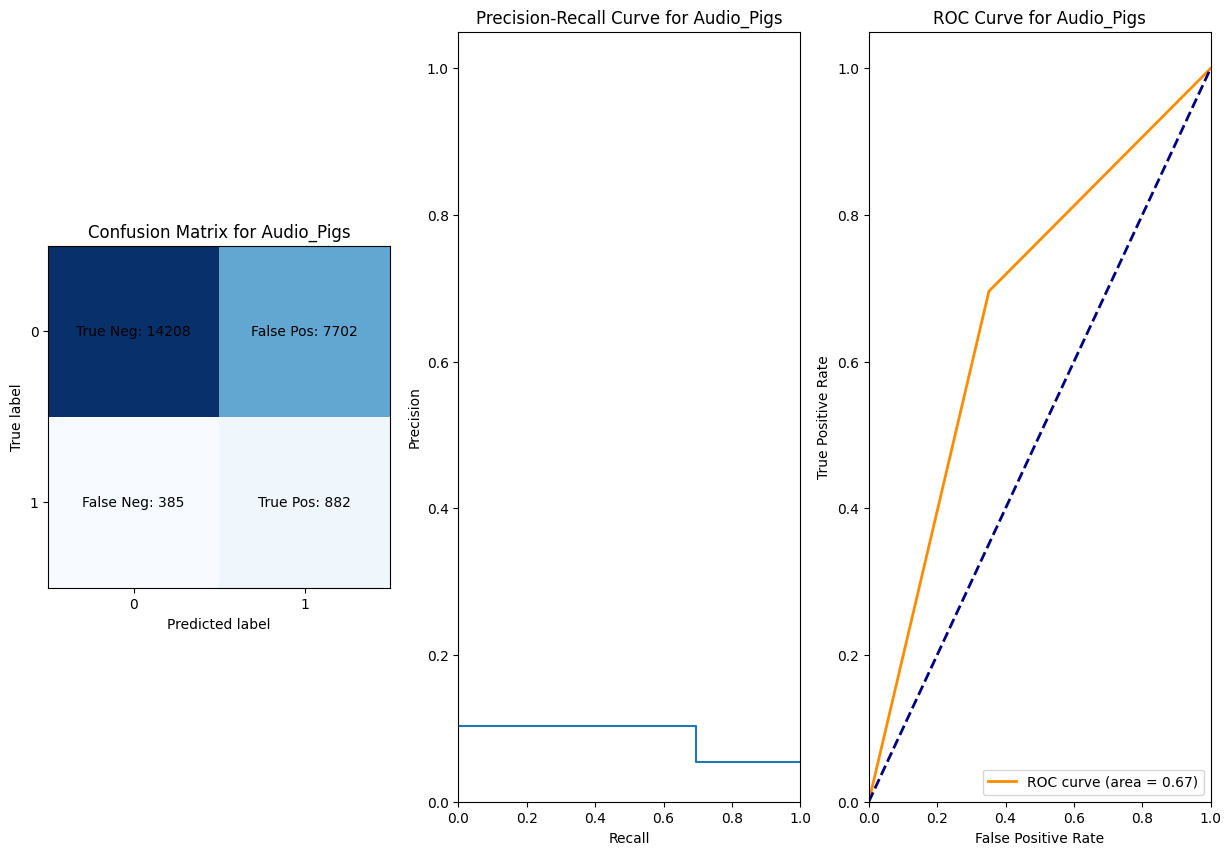

In [324]:
accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

mfcc +chroma: ok

In [318]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.6600077663200586
Precision: 0.10472205618649133
Recall: 0.691397000789266
F1 Score: 0.18189368770764117
Confusion Matrix:
[[14421  7489]
 [  391   876]]


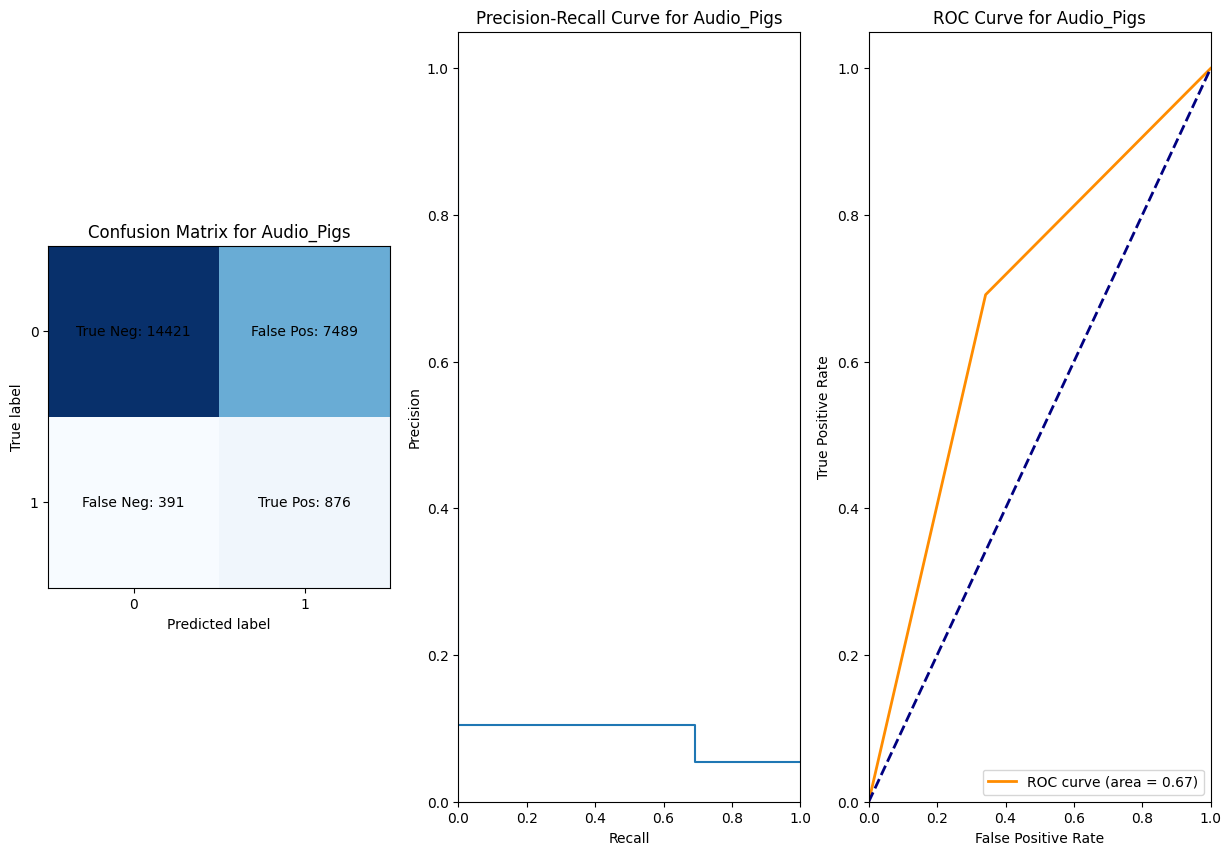

In [319]:
accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [ ]:
poly & sharpness: bad

In [310]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.4950597575182293
Precision: 0.06407685881370091
Recall: 0.6053670086819258
F1 Score: 0.11588728563873989
Confusion Matrix:
[[10707 11203]
 [  500   767]]


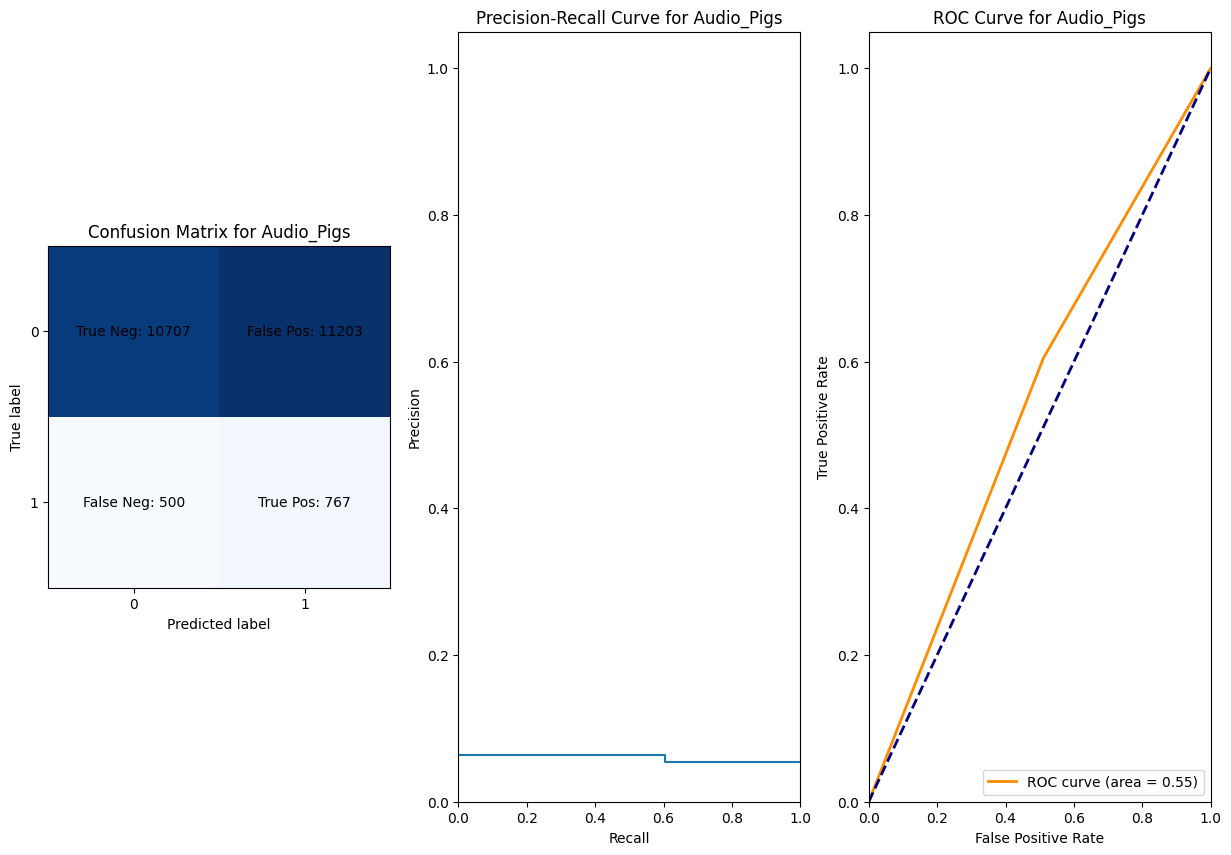

In [311]:
accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

MFCC chroma sharpness

In [313]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.4950597575182293
Precision: 0.06407685881370091
Recall: 0.6053670086819258
F1 Score: 0.11588728563873989
Confusion Matrix:
[[10707 11203]
 [  500   767]]


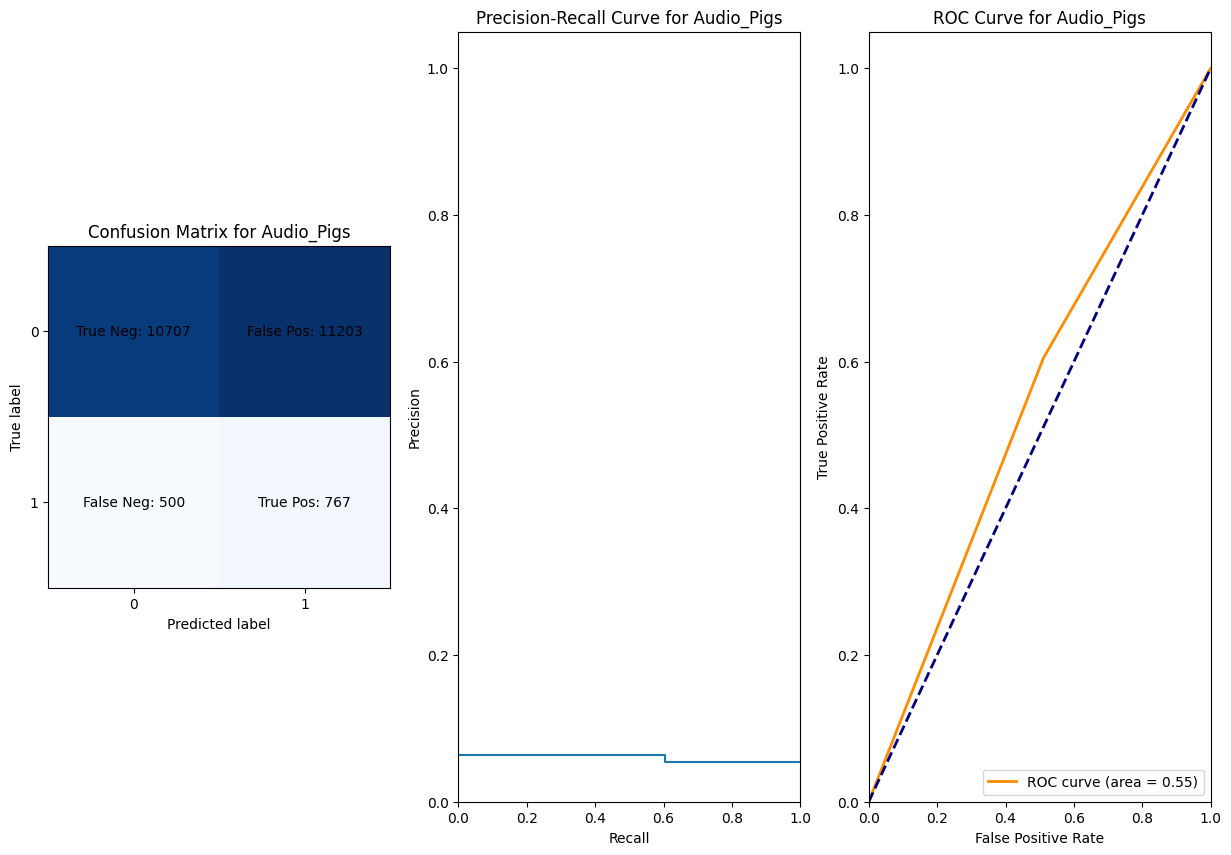

In [314]:
accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

All featues: poly, mfcc, spectral_contrast, chroma, sharpness, spectral rolloff

In [362]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.651076498252578
Precision: 0.1027493010251631
Recall: 0.6961325966850829
F1 Score: 0.17906811491219166
Confusion Matrix:
[[14208  7702]
 [  385   882]]


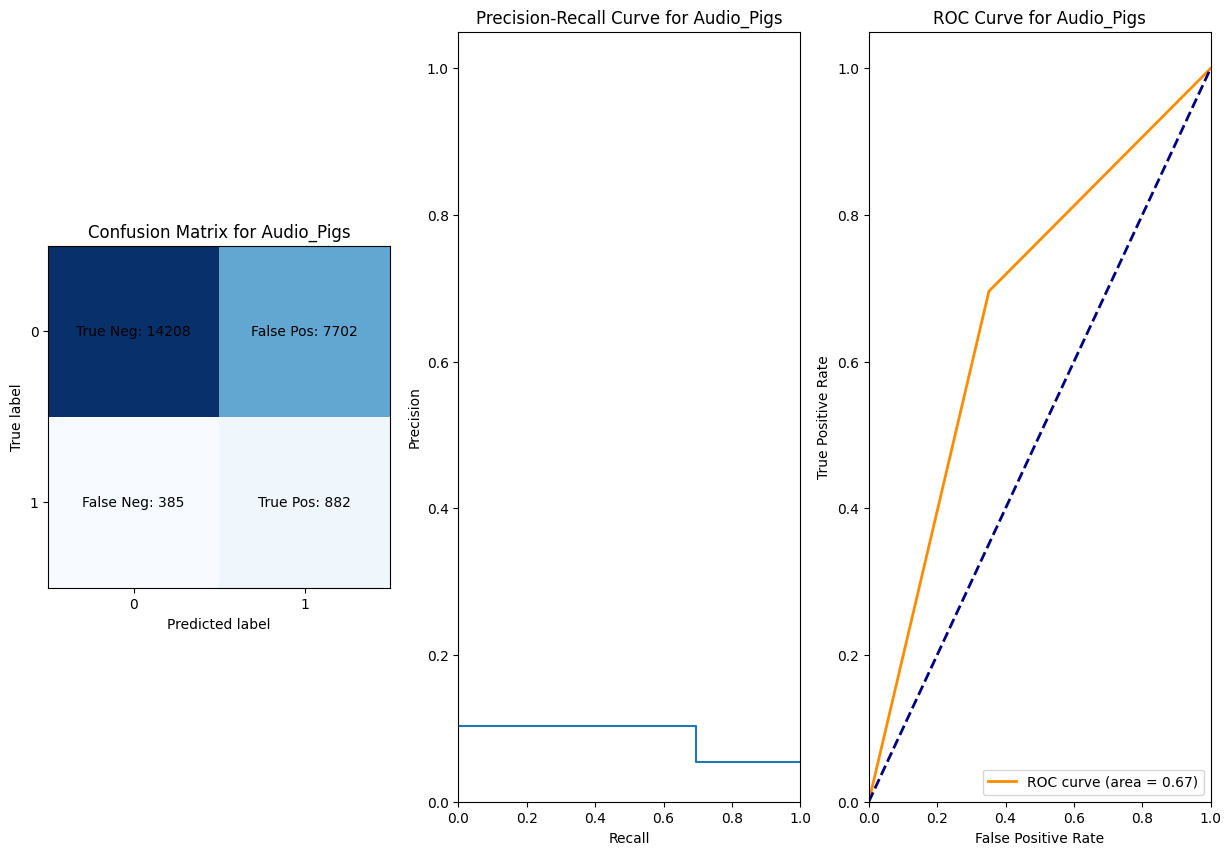

In [363]:
accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: 
Accuracy: 0.651076498252578
Precision: 0.1027493010251631
Recall: 0.6961325966850829
F1 Score: 0.17906811491219166
Confusion Matrix:
[[14208  7702]
 [  385   882]]


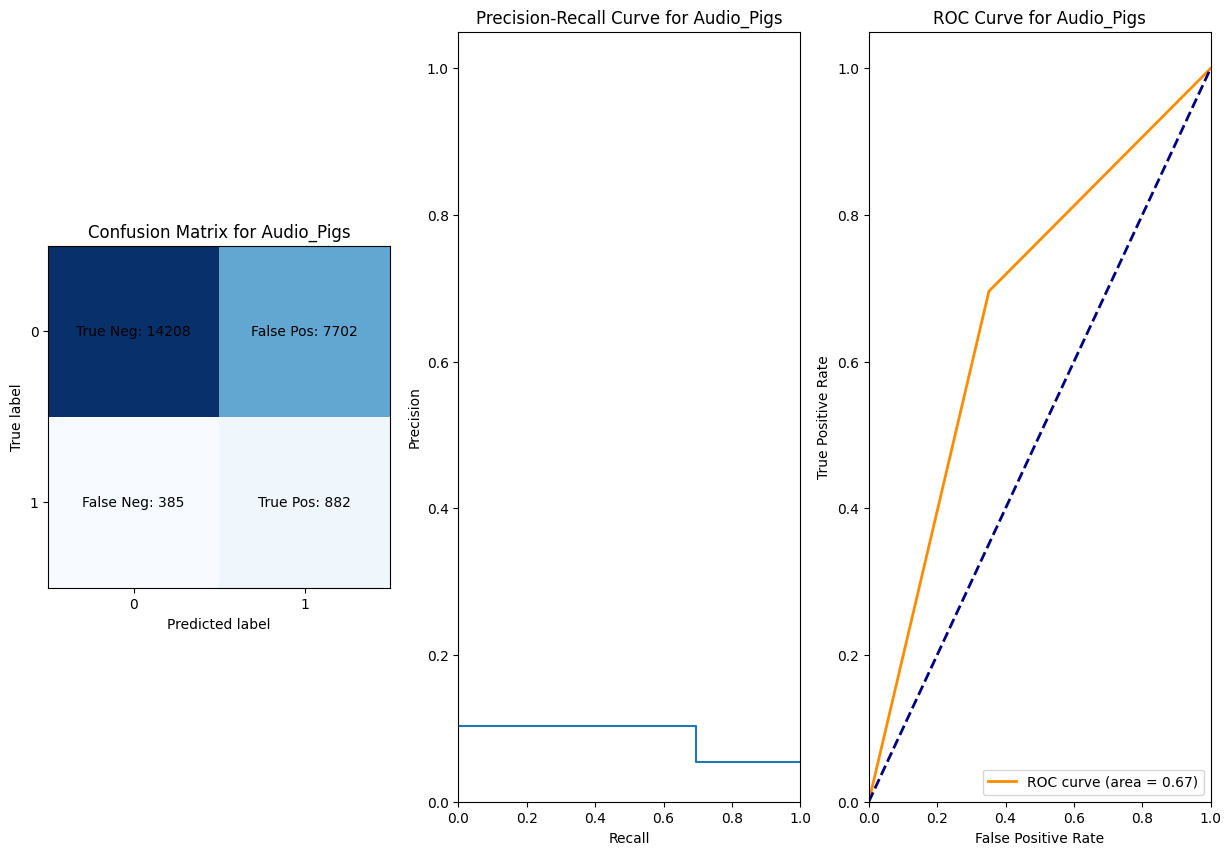

In [328]:
#evaluation metrics for pigs
#ridge classifier balanced, svd


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd, all features: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [364]:
#cook
rc_cook = RidgeClassifier(class_weight='balanced',solver='svd')
rc_cook.fit(X_train,y_train["Audio_Cook"])
y_pred_cook = rc_cook.predict(X_test)


Metrics for Audio_Cook : 
Accuracy: 0.7689088320317556
Precision: 0.045823561248421435
Recall: 0.7912772585669782
F1 Score: 0.08663028649386084
Confusion Matrix:
[[17567  5289]
 [   67   254]]


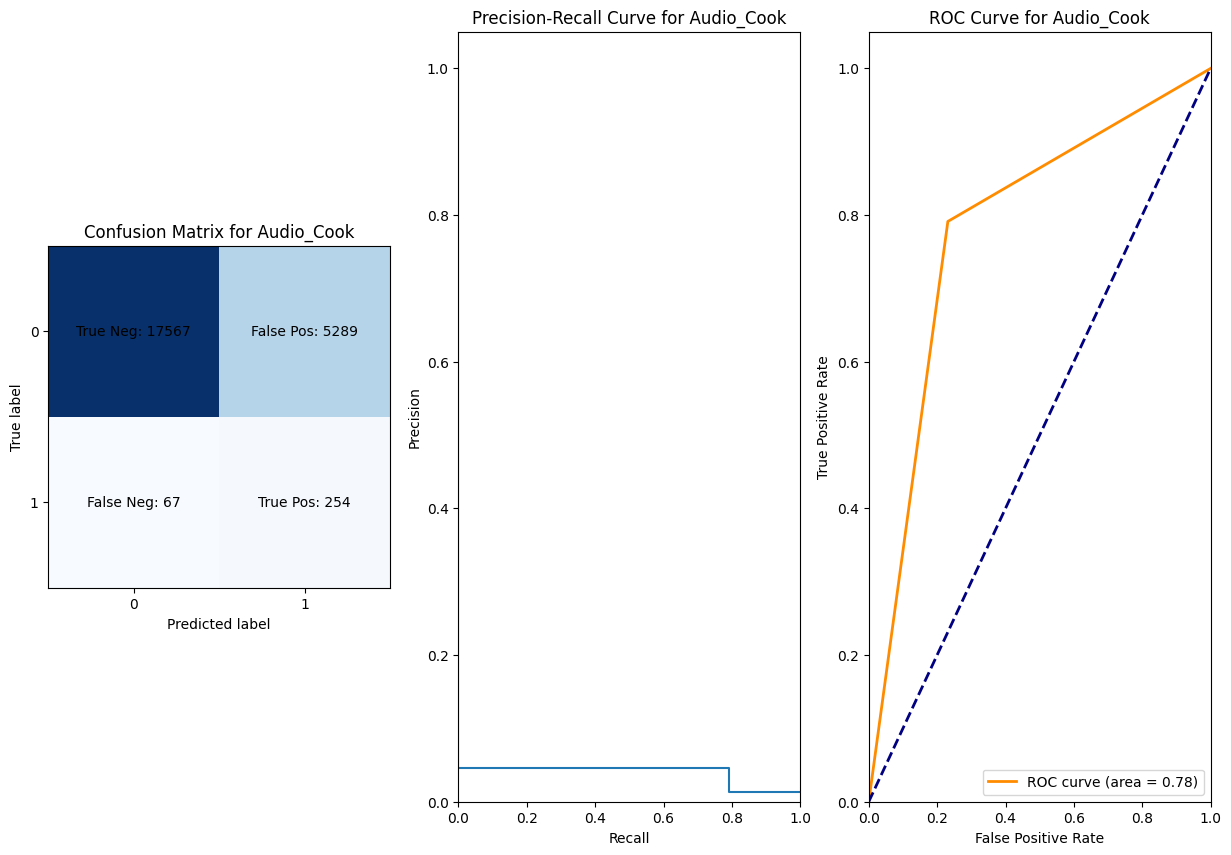

In [365]:
accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"],y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook : ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"], y_pred_cook, "Precision-Recall Curve for Audio_Cook", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

In [366]:
rc_mp = RidgeClassifier(class_weight='balanced',solver='svd')
rc_mp.fit(X_train,y_train["Audio_MissPiggy"])
y_pred_mp = rc_mp.predict(X_test)

Metrics for Audio_MissPiggy : 
Accuracy: 0.6851188678431204
Precision: 0.0807081489195522
Recall: 0.7242990654205608
F1 Score: 0.14523307566174748
Confusion Matrix:
[[15259  7062]
 [  236   620]]


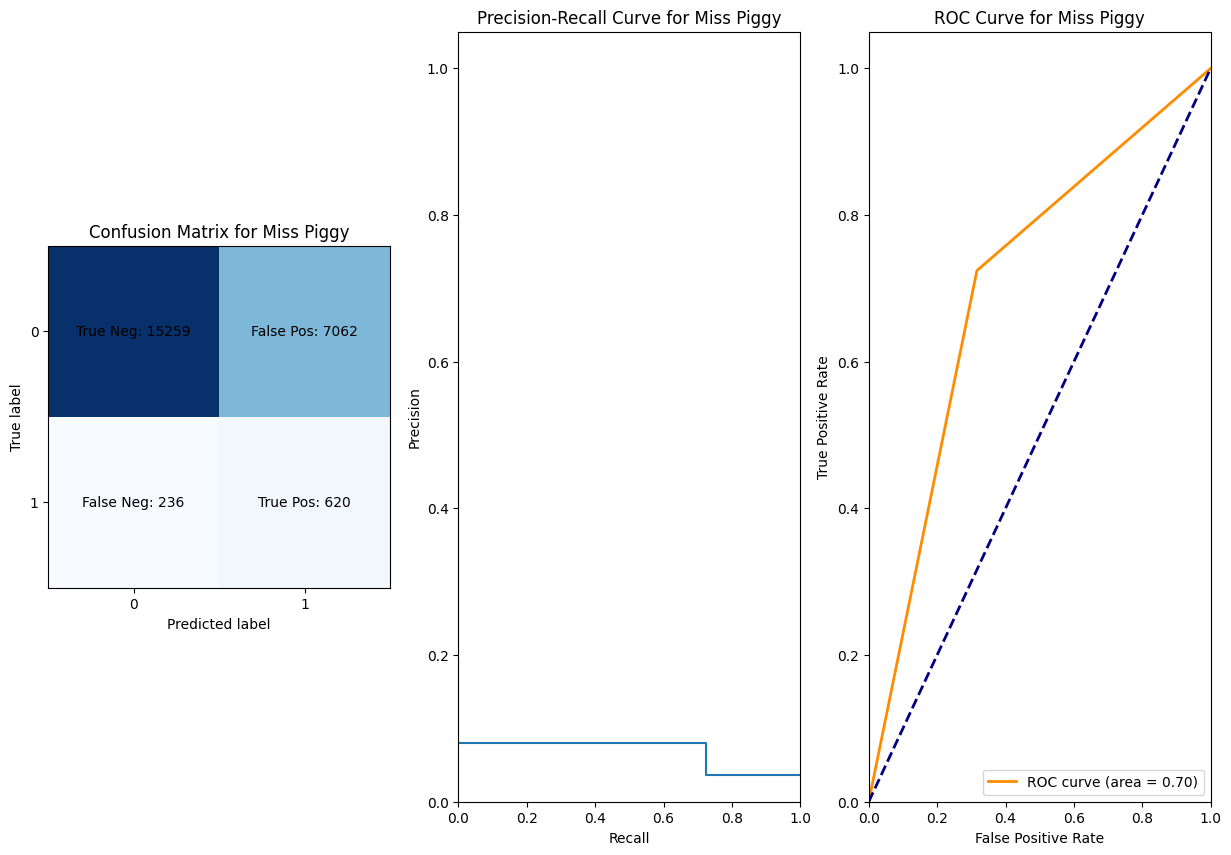

In [367]:
accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy : ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Miss Piggy", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Miss Piggy", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Miss Piggy", ax=axs[2])

none        =   0
only pigs   =   1
only cook   =   2
only mp     =   4
pigs & cook =   3
pigs & mp   =   5
mp & cook   =   6
all         =   7

In [368]:
#combined metrics
y_test["combined"] = y_test["Audio_Pigs"] + y_test["Audio_Cook"] *2 + y_test["Audio_MissPiggy"]*4
combined_pred = y_pred_pigs + y_pred_cook *2 + y_pred_mp*4



In [369]:
print(y_test["combined"].shape)
print(len(combined_pred))

(23177,)
23177


c:\Users\alina\Documents\GitHub\similarity-modeling\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4449238469172024
Precision: 0.9120687924360174
Recall: 0.4449238469172024
F1 Score: 0.5766860010524871
Confusion Matrix:
[[9594 1196 3298  617  969 4851  132  932]
 [  84   65   60   73    4   99    3   23]
 [  32   13  177   50    4   18    2   25]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [ 140   38   37   21   51  476    6   87]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]


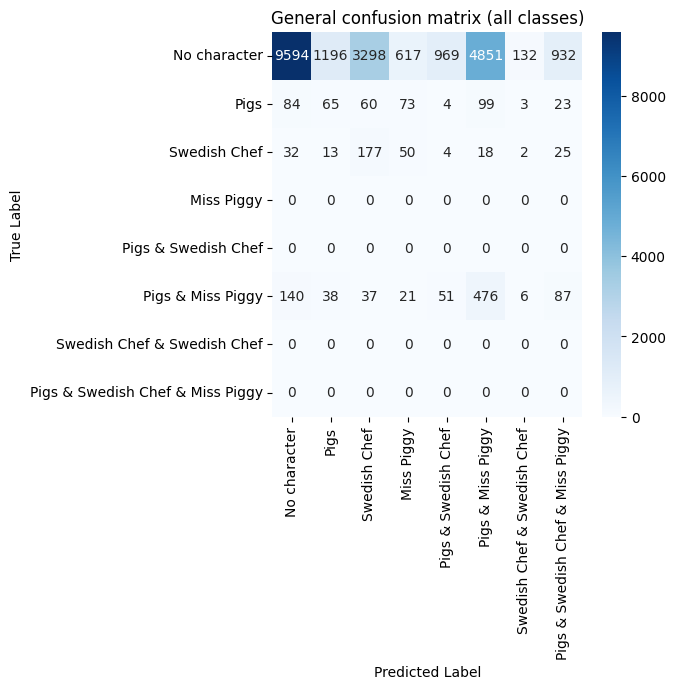

In [370]:
#combined evaluation metrics
# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test['combined'], combined_pred)
precision_general = precision_score(y_test["combined"], combined_pred, average="weighted")
recall_general = recall_score(y_test["combined"],combined_pred, average="weighted")
f1_general = f1_score(y_test["combined"], combined_pred, average="weighted")
conf_matrix_general = confusion_matrix(y_test["combined"], combined_pred)

print(f"Accuracy: {accuracy_general}")
print(f"Precision: {precision_general}")
print(f"Recall: {recall_general}")
print(f"F1 Score: {f1_general}")
print(f"Confusion Matrix:\n{conf_matrix_general}")

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plot_global_confusion_matrix_sm2(
    y_test["combined"],
    combined_pred,
    "Pigs",
    "Swedish Chef",
    "Miss Piggy"
 
)

poly features + all mfccs
pigs: better than poly only
cook: much better than poly only
miss piggy: better than poly only

In [230]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

In [232]:
#cook
rc_cook = RidgeClassifier(class_weight='balanced',solver='svd')
rc_cook.fit(X_train,y_train["Audio_Cook"])
y_pred_cook = rc_cook.predict(X_test)

In [234]:
rc_mp = RidgeClassifier(class_weight='balanced',solver='svd')
rc_mp.fit(X_train,y_train["Audio_MissPiggy"])
y_pred_mp = rc_mp.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd Color only: 
Accuracy: 0.6501704275790654
Precision: 0.10305210630149704
Recall: 0.7008681925808997
F1 Score: 0.17968433832456493
Confusion Matrix:
[[14181  7729]
 [  379   888]]


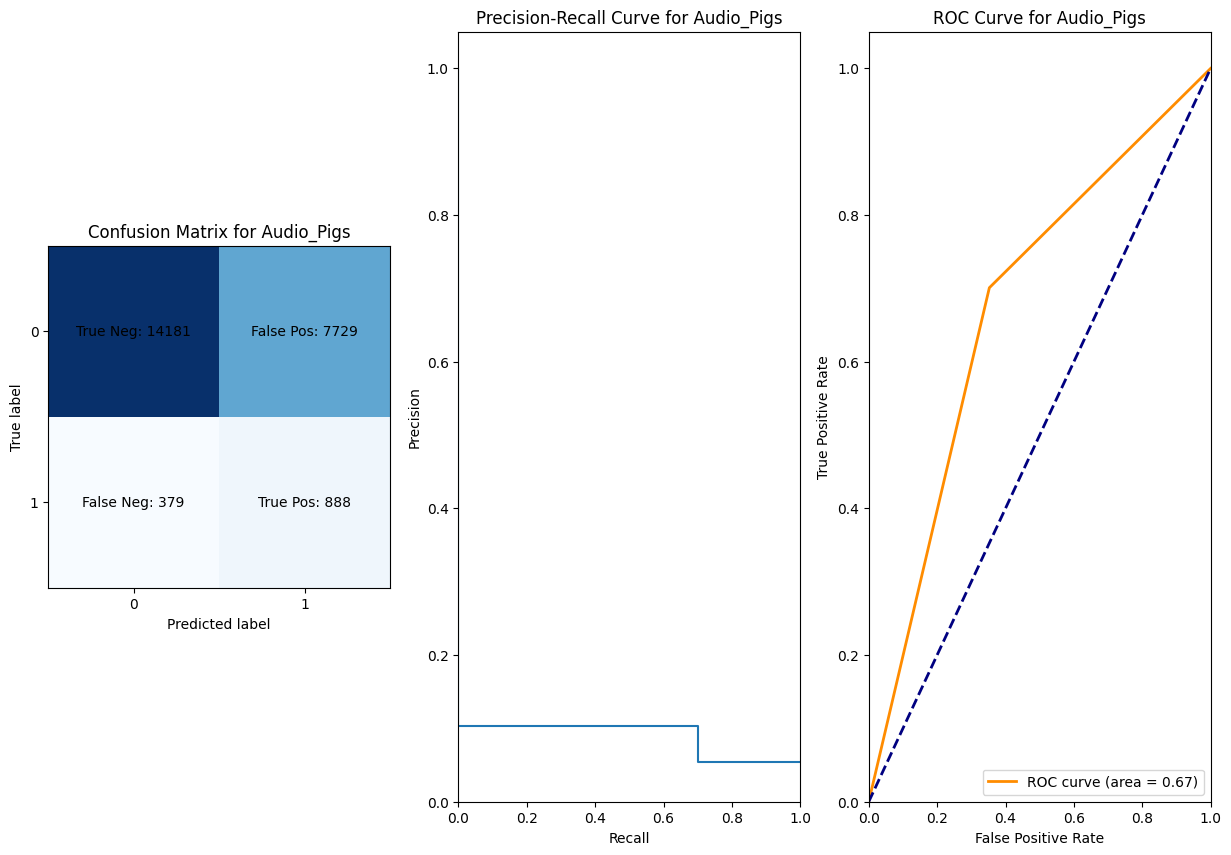

In [231]:
#evaluation metrics for pigs
#ridge classifier balanced, svd


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

Metrics for Audio_Cook Predominant Color only: 
Accuracy: 0.7631272382102947
Precision: 0.04490227152667723
Recall: 0.794392523364486
F1 Score: 0.08499999999999999
Confusion Matrix:
[[17432  5424]
 [   66   255]]


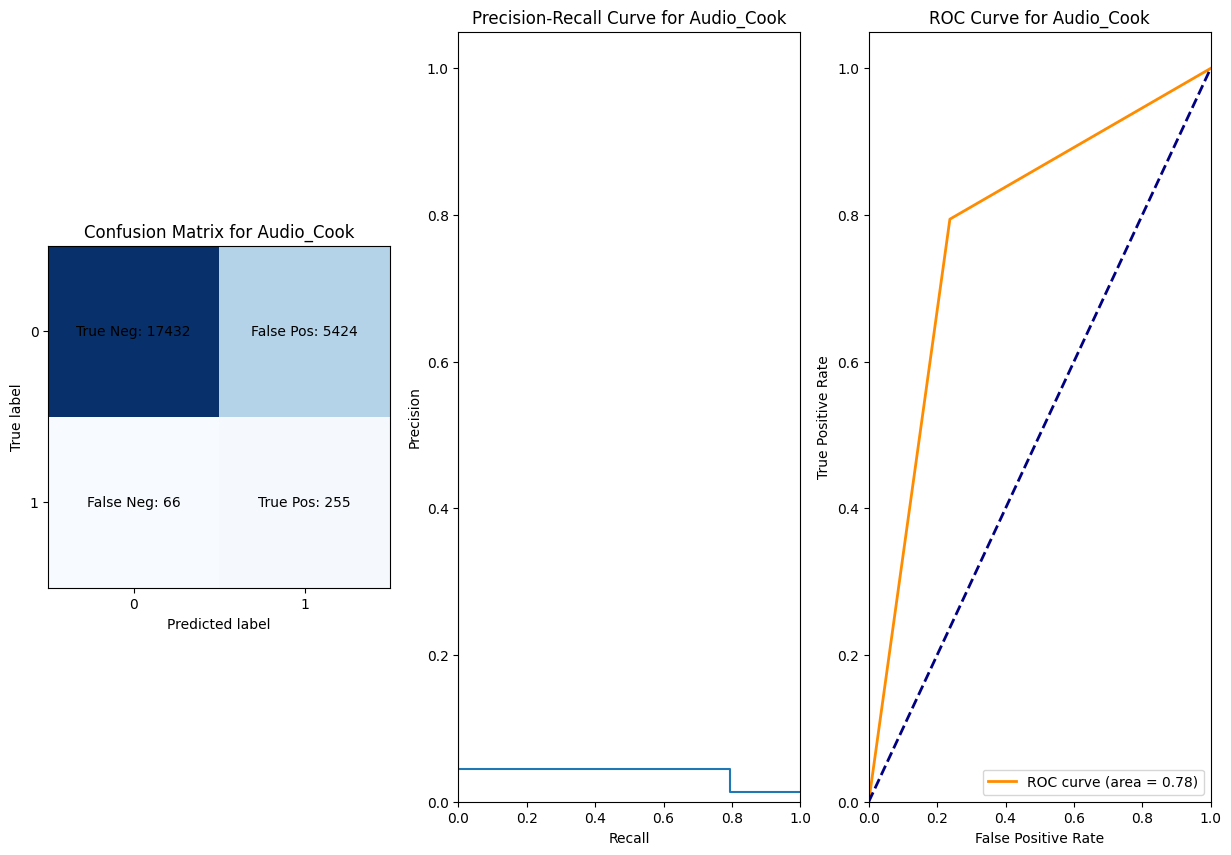

In [233]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"],y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"], y_pred_cook, "Precision-Recall Curve for Audio_Cook", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

Metrics for Audio_MissPiggy Predominant Color only: 
Accuracy: 0.6673857703758036
Precision: 0.07535010534143016
Recall: 0.7102803738317757
F1 Score: 0.13624649859943977
Confusion Matrix:
[[14860  7461]
 [  248   608]]


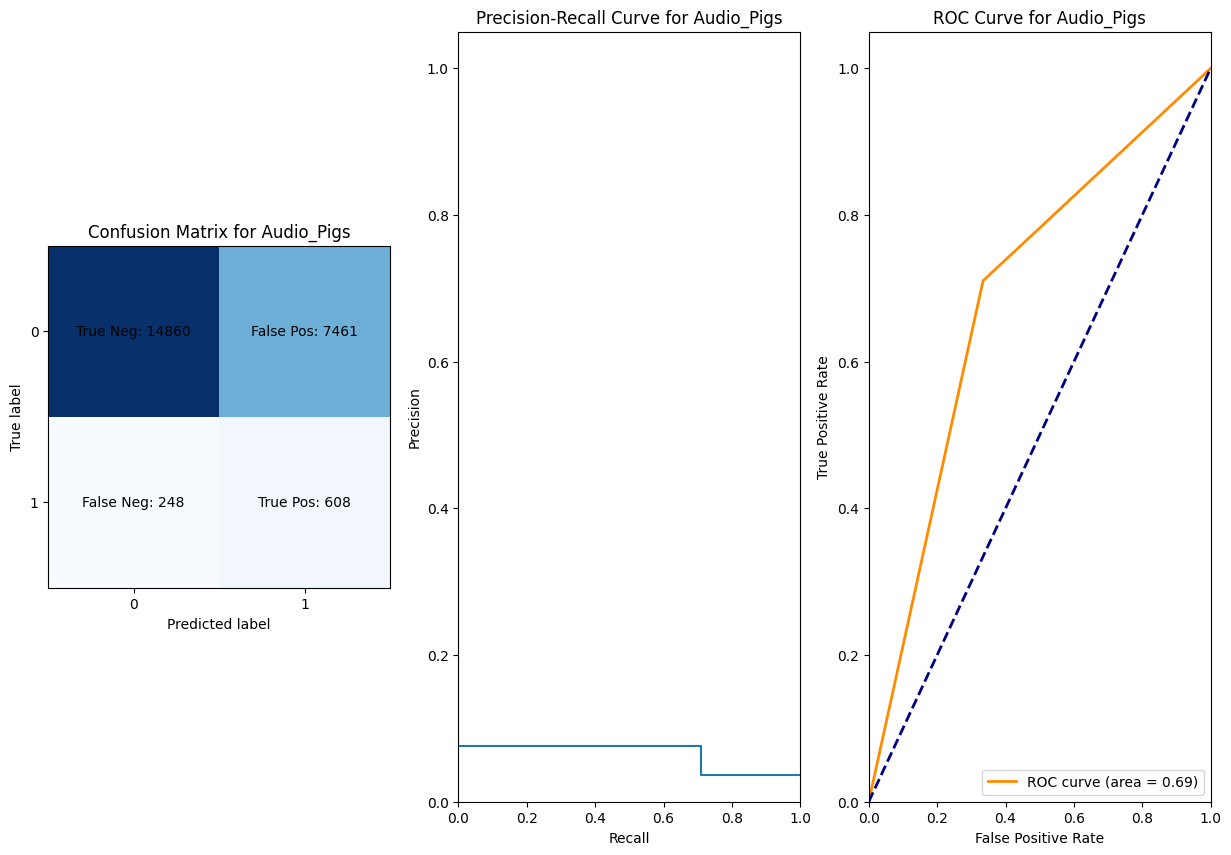

In [235]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Audio_Pigs", ax=axs[2])

Ridge classifier for poly features only
does not perform well for pigs
performs badly for cook
does not perform well for miss piggy

In [212]:
#pigs
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd Color only: 
Accuracy: 0.4952323424084221
Precision: 0.06409827845562427
Recall: 0.6053670086819258
F1 Score: 0.11592231542356231
Confusion Matrix:
[[10711 11199]
 [  500   767]]


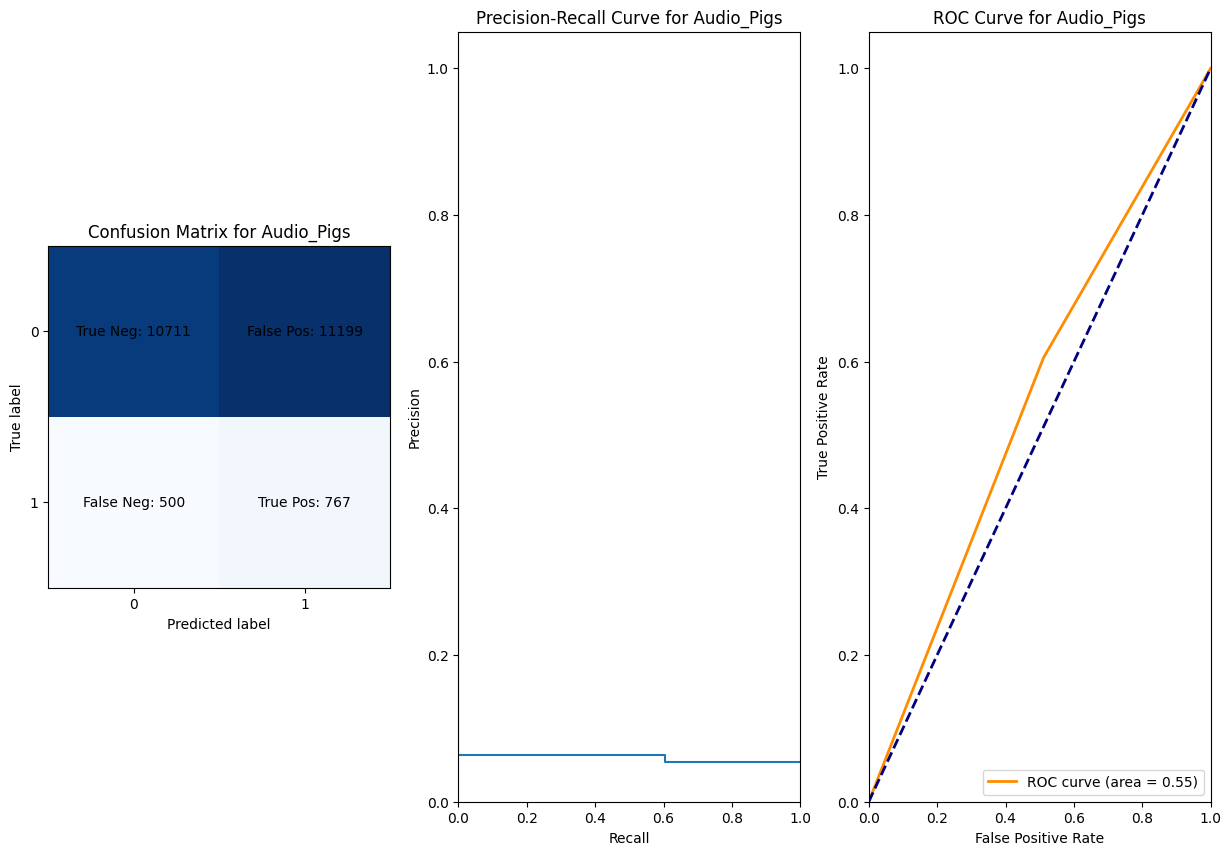

In [213]:
#evaluation metrics for pigs
#ridge classifier balanced, svd


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [214]:
#cook
#pigs
rc_cook = RidgeClassifier(class_weight='balanced',solver='svd')
rc_cook.fit(X_train,y_train["Audio_Cook"])
y_pred_cook = rc_cook.predict(X_test)

Metrics for Audio_Cook Predominant Color only: 
Accuracy: 0.5637053975924408
Precision: 0.014768559817623154
Recall: 0.46417445482866043
F1 Score: 0.028626320845341016
Confusion Matrix:
[[12916  9940]
 [  172   149]]


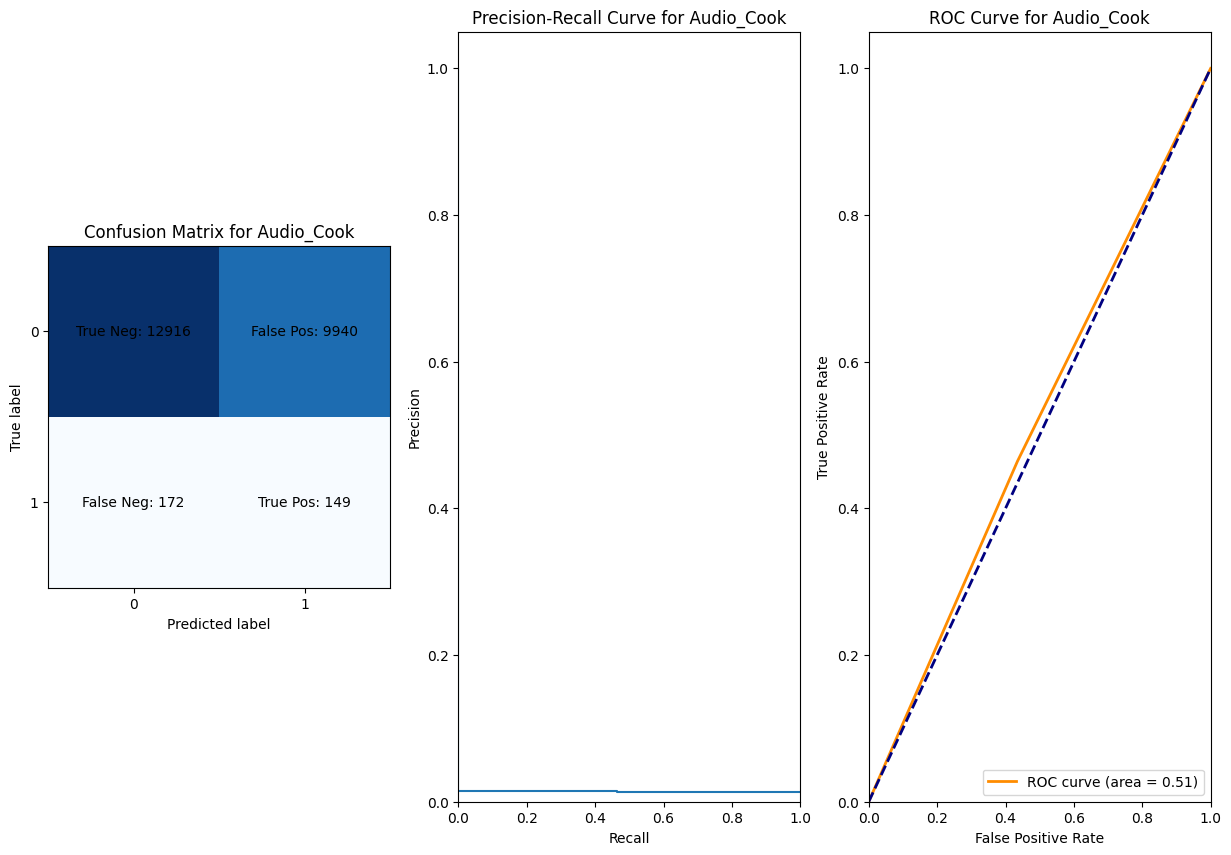

In [215]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"],y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"], y_pred_cook, "Precision-Recall Curve for Audio_Cook", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

In [216]:
#miss piggy
rc_mp = RidgeClassifier(class_weight='balanced',solver='svd')
rc_mp.fit(X_train,y_train["Audio_MissPiggy"])
y_pred_mp = rc_mp.predict(X_test)

Metrics for Audio_MissPiggy Predominant Color only: 
Accuracy: 0.5052422660396082
Precision: 0.046344591705857204
Recall: 0.633177570093458
F1 Score: 0.08636762010995139
Confusion Matrix:
[[11168 11153]
 [  314   542]]


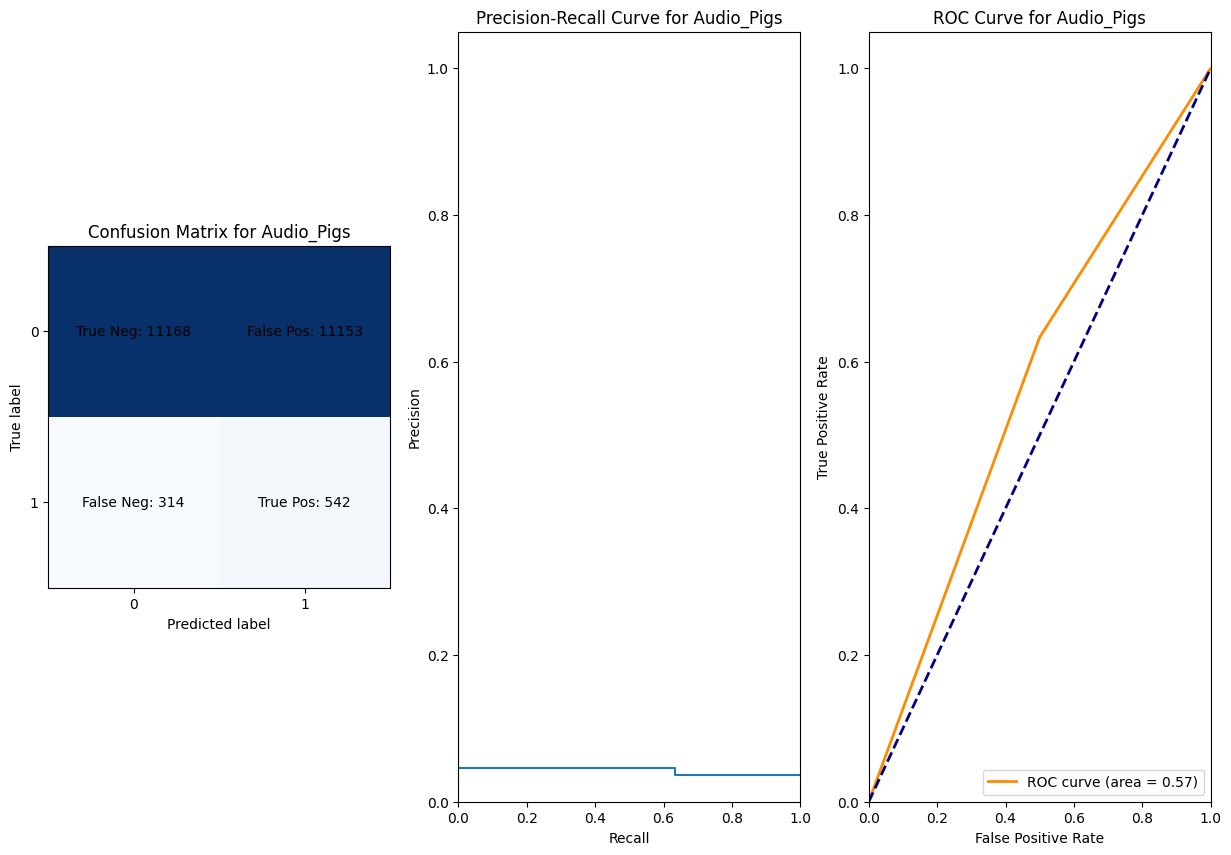

In [217]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Audio_Pigs", ax=axs[2])

In [16]:
#ridge
#pigs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
max_iter=100
rc_pigs = RidgeClassifier()
rc_pigs.fit(X_train,y_train["Audio_Pigs"])

if rc_pigs.n_iter_ == max_iter:
    print("Solver has reached the maximum number of iterations. Consider increasing max_iter.")
else:
    print("Solver has converged within the specified max_iter.")

y_pred_pigs = rc_pigs.predict(X_test)

Solver has converged within the specified max_iter.


Ridge Classifier with all features from SM 1:
loudness_rms	zcr	spectral_contrast_1	spectral_contrast_2	spectral_contrast_3	spectral_contrast_4	spectral_contrast_5	spectral_contrast_6	chroma1	chroma2	...	mfcc12	mfcc13	mfcc14	mfcc15	mfcc16	mfcc17	mfcc18	mfcc19	spectral_rolloff	spectral_centroid

unable to extract new features except for poly features due to inappropriate array shapes and parameter errors of win_length: for tonnetz, tempo, tempogram, ....

Ridge Classification for Pigs: 

In [152]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='svd')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, svd Color only: 
Accuracy: 0.6688095957198947
Precision: 0.10782034022763431
Recall: 0.6953433307024467
F1 Score: 0.18669209578300489
Confusion Matrix:
[[14620  7290]
 [  386   881]]


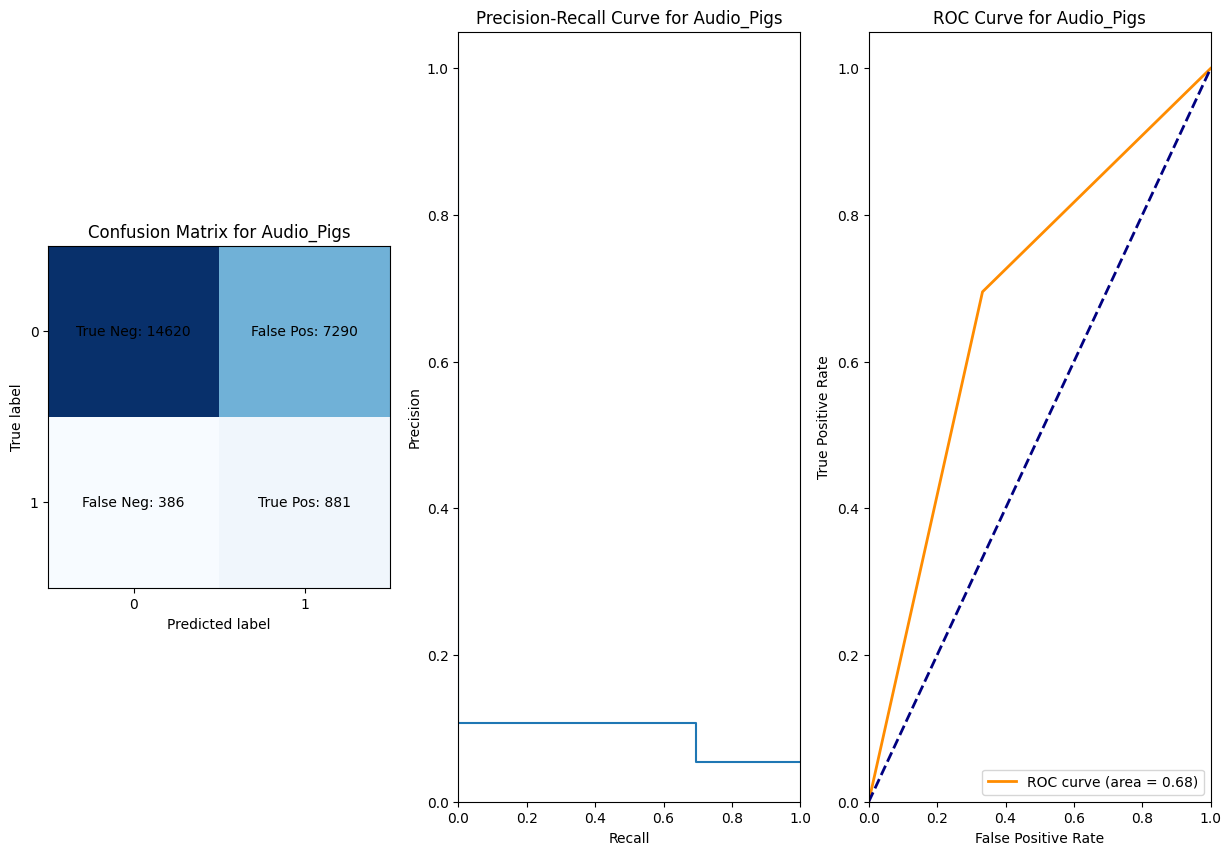

In [154]:
#evaluation metrics for pigs
#ridge classifier balanced, svd


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, svd Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

Ridge Classification for Cook


In [177]:
rc_cook = RidgeClassifier(class_weight='balanced',solver='svd')
rc_cook.fit(X_train,y_train["Audio_Cook"])
y_pred_cook = rc_cook.predict(X_test)

Metrics for Audio_Cook Predominant Color only: 
Accuracy: 0.7755964965267291
Precision: 0.04663693794128577
Recall: 0.7819314641744548
F1 Score: 0.08802384709801858
Confusion Matrix:
[[17725  5131]
 [   70   251]]


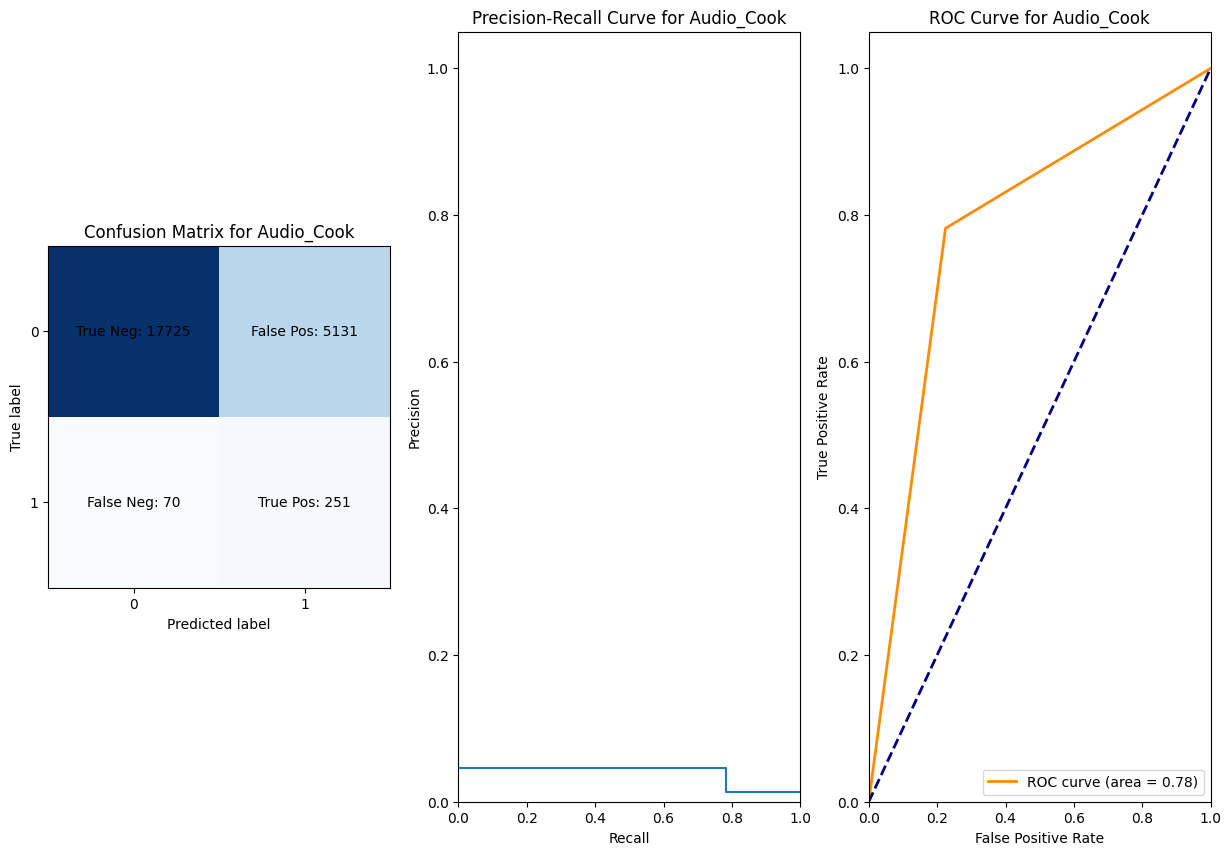

In [178]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"],y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"], y_pred_cook, "Precision-Recall Curve for Audio_Cook", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

ridge classifier for miss piggy

In [179]:
rc_mp = RidgeClassifier(class_weight='balanced',solver='svd')
rc_mp.fit(X_train,y_train["Audio_MissPiggy"])
y_pred_mp = rc_mp.predict(X_test)

Metrics for Audio_MissPiggy Predominant Color only: 
Accuracy: 0.7050955688829443
Precision: 0.08748447633503519
Recall: 0.7406542056074766
F1 Score: 0.15648525237566333
Confusion Matrix:
[[15708  6613]
 [  222   634]]


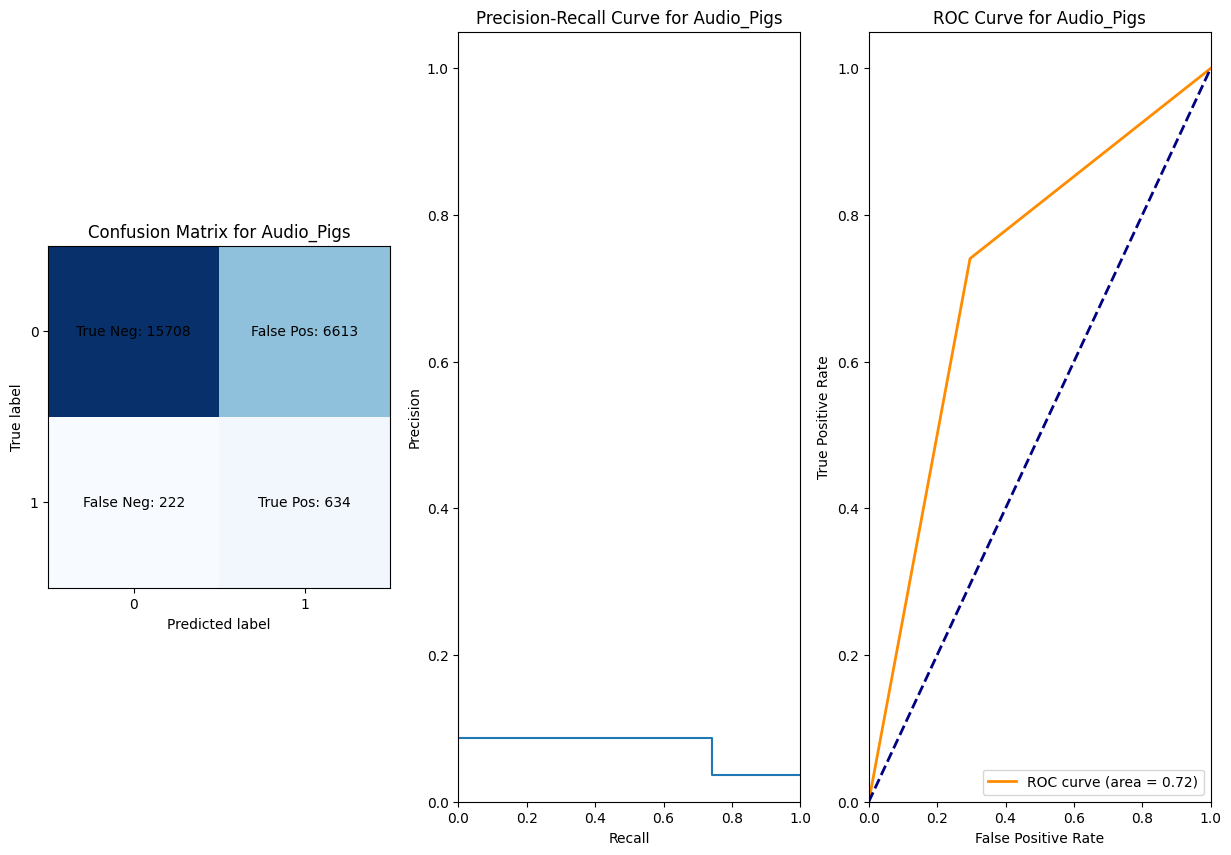

In [180]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for Audio_Pigs", ax=axs[2])

Further experiments with different ridgeclassifier solvers - did not turn out to work better than svd. But without setting the solver='svd' der results were miserable. 

In [155]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='cholesky')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, cholesky: 
Accuracy: 0.6688095957198947
Precision: 0.10782034022763431
Recall: 0.6953433307024467
F1 Score: 0.18669209578300489
Confusion Matrix:
[[14620  7290]
 [  386   881]]


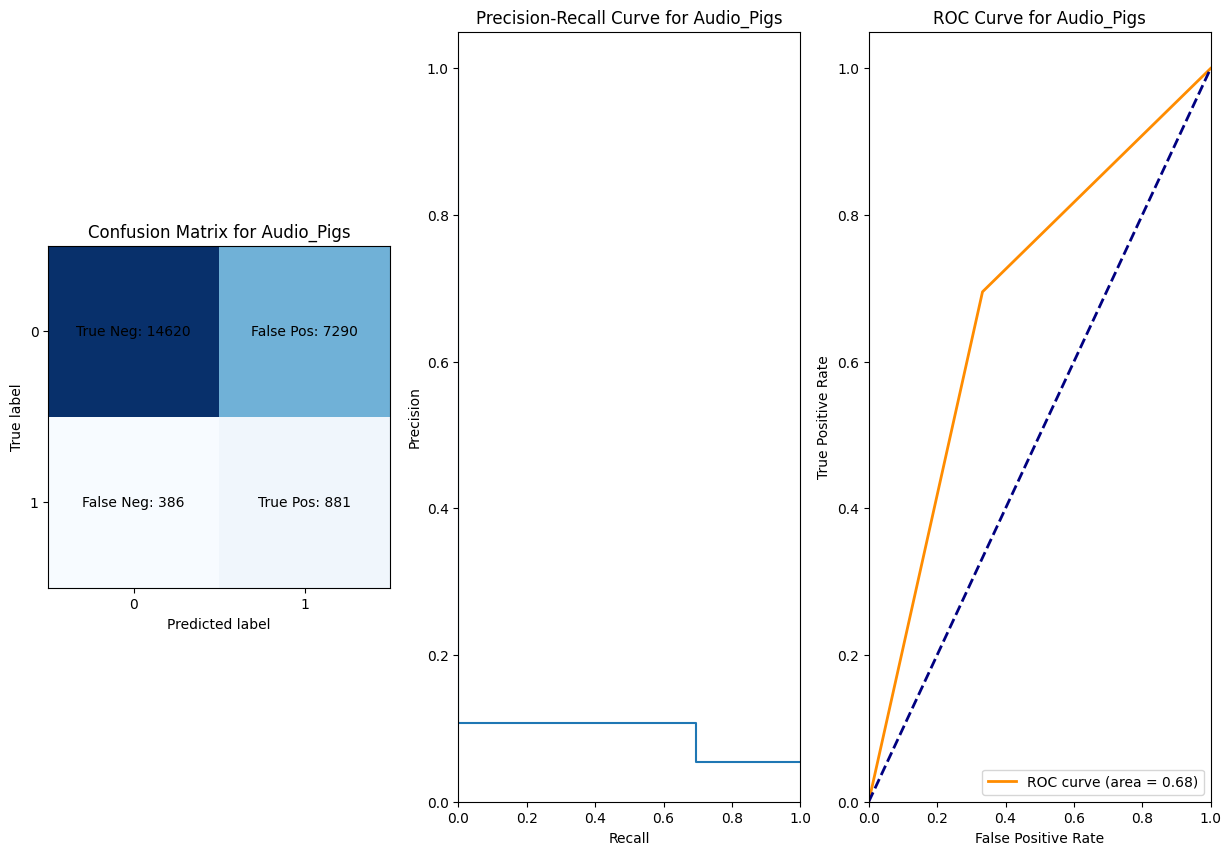

In [156]:
#evaluation metrics for pigs
#ridge classifier balanced, cholesky


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, cholesky: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [157]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='lsqr')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, lsqr: 
Accuracy: 0.6686370108297018
Precision: 0.10767160161507403
Recall: 0.6945540647198106
F1 Score: 0.18644067796610167
Confusion Matrix:
[[14617  7293]
 [  387   880]]


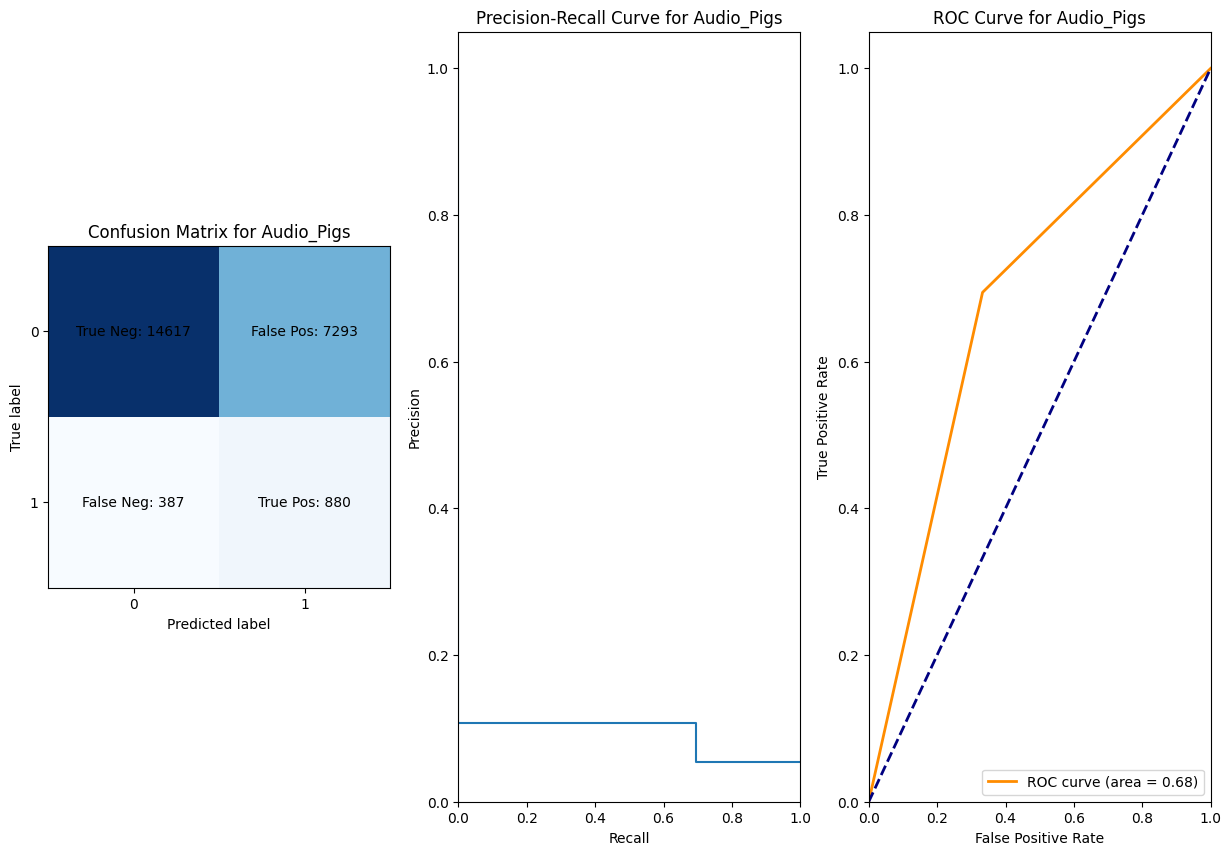

In [158]:
#evaluation metrics for pigs
#ridge classifier balanced, lsqr


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, lsqr: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [159]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='sparse_cg')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, sparse cg: 
Accuracy: 0.6688527419424429
Precision: 0.10783353733170134
Recall: 0.6953433307024467
F1 Score: 0.18671187877503442
Confusion Matrix:
[[14621  7289]
 [  386   881]]


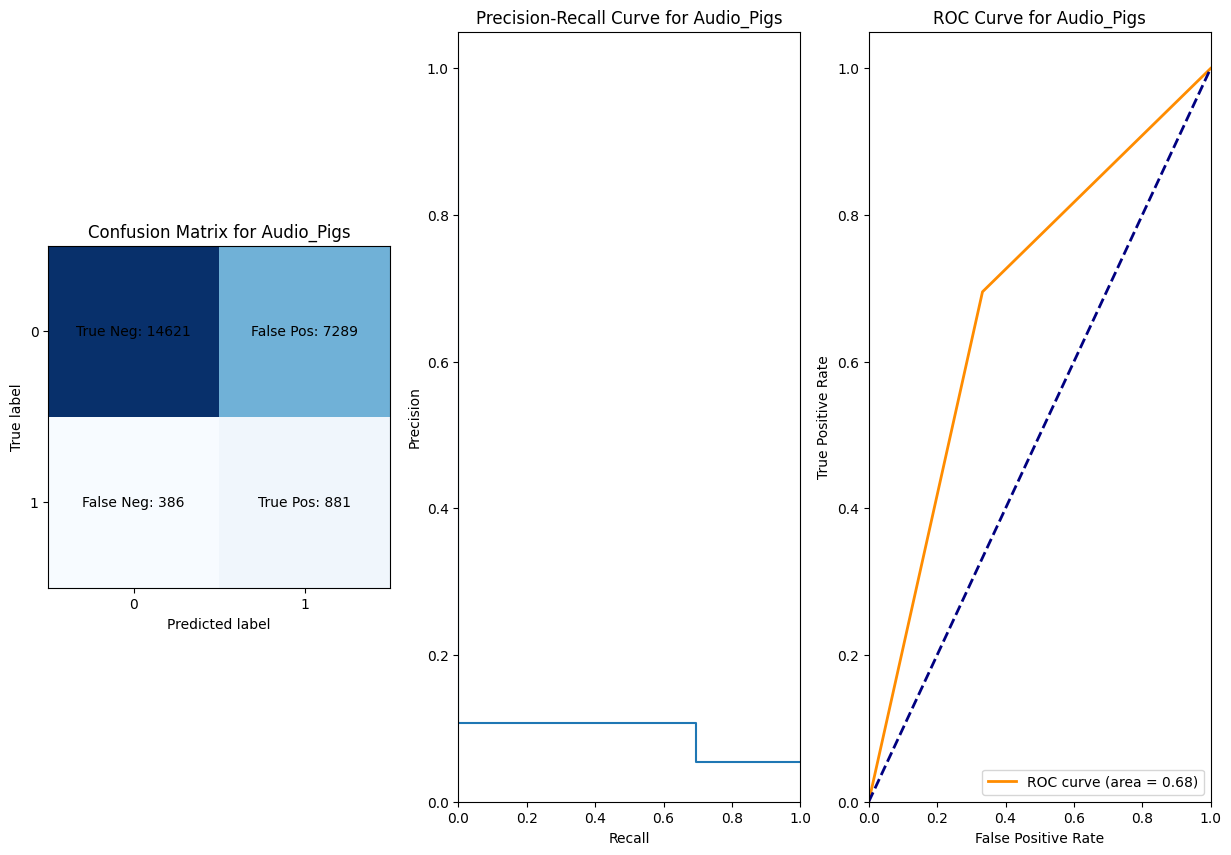

In [160]:
#evaluation metrics for pigs
#ridge classifier balanced, sparse_cg


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, sparse cg: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

Metrics for Audio_Pigs ridge classifier, balanced, sag: 
Accuracy: 0.66868015705225
Precision: 0.10778076828969904
Recall: 0.6953433307024467
F1 Score: 0.18663277195212372
Confusion Matrix:
[[14617  7293]
 [  386   881]]


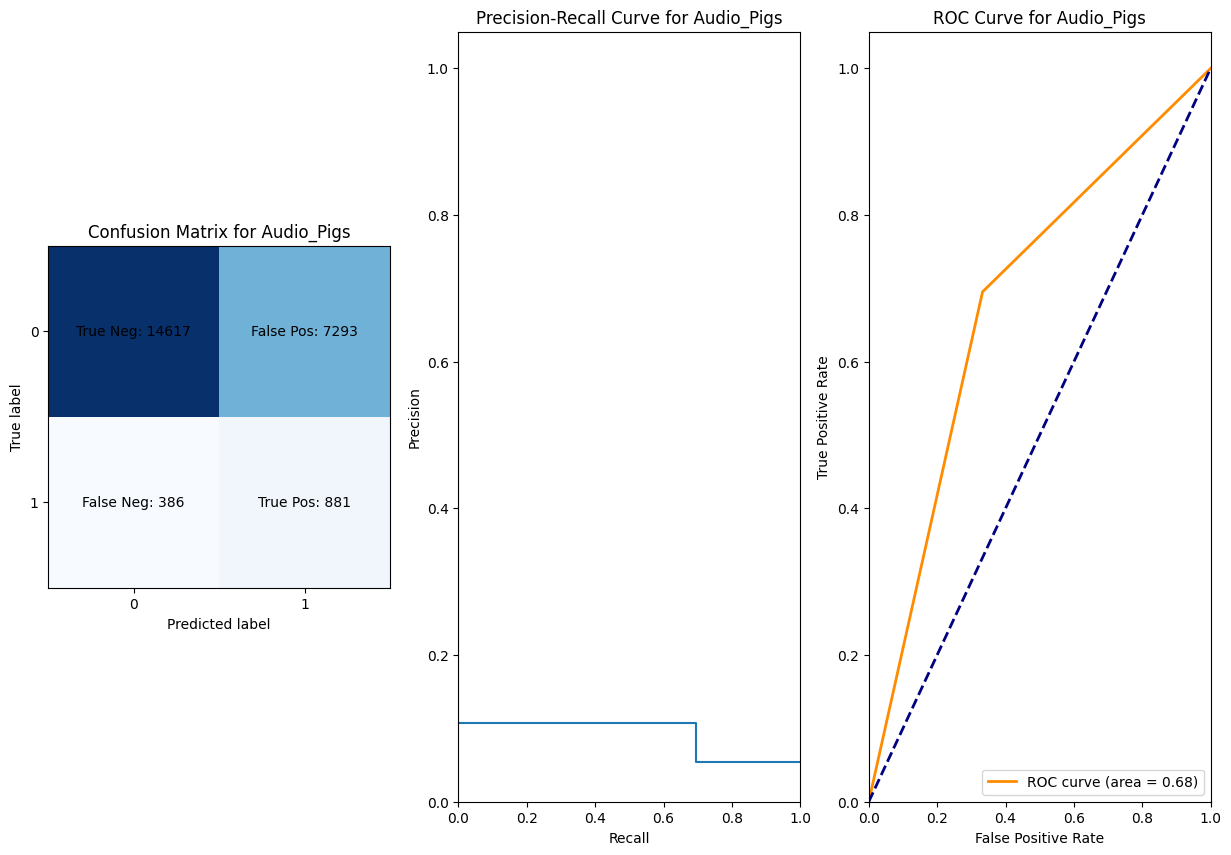

In [162]:
#evaluation metrics for pigs
#ridge classifier balanced, ssag


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, sag: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [161]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='sag')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

In [163]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='saga')
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, saga: 
Accuracy: 0.6688095957198947
Precision: 0.10782034022763431
Recall: 0.6953433307024467
F1 Score: 0.18669209578300489
Confusion Matrix:
[[14620  7290]
 [  386   881]]


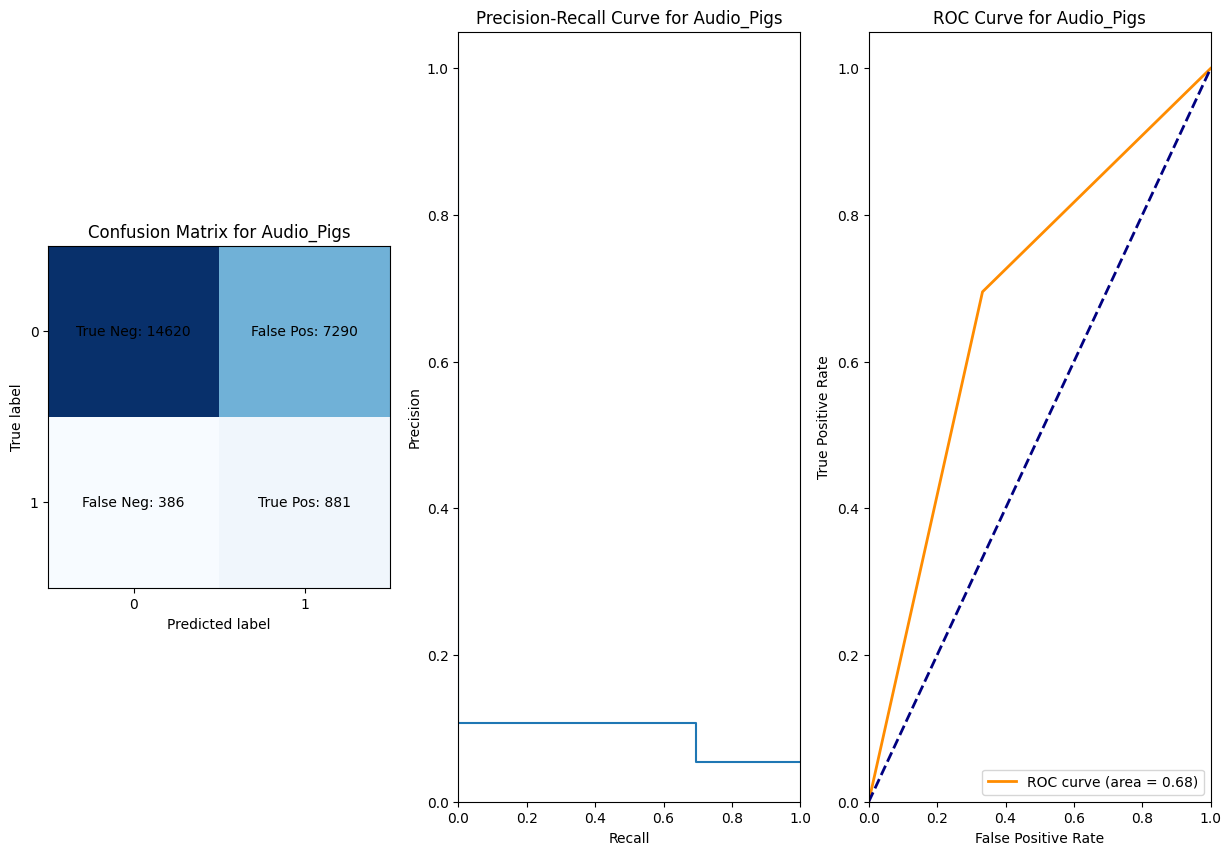

In [164]:
#evaluation metrics for pigs
#ridge classifier balanced, saga


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, saga: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [166]:
rc_pigs = RidgeClassifier(class_weight='balanced',solver='lbfgs',positive=True)
rc_pigs.fit(X_train,y_train["Audio_Pigs"])
y_pred_pigs = rc_pigs.predict(X_test)

Metrics for Audio_Pigs ridge classifier, balanced, sag: 
Accuracy: 0.60072485653881
Precision: 0.0794102159031069
Recall: 0.5951065509076559
F1 Score: 0.14012265378182492
Confusion Matrix:
[[13169  8741]
 [  513   754]]


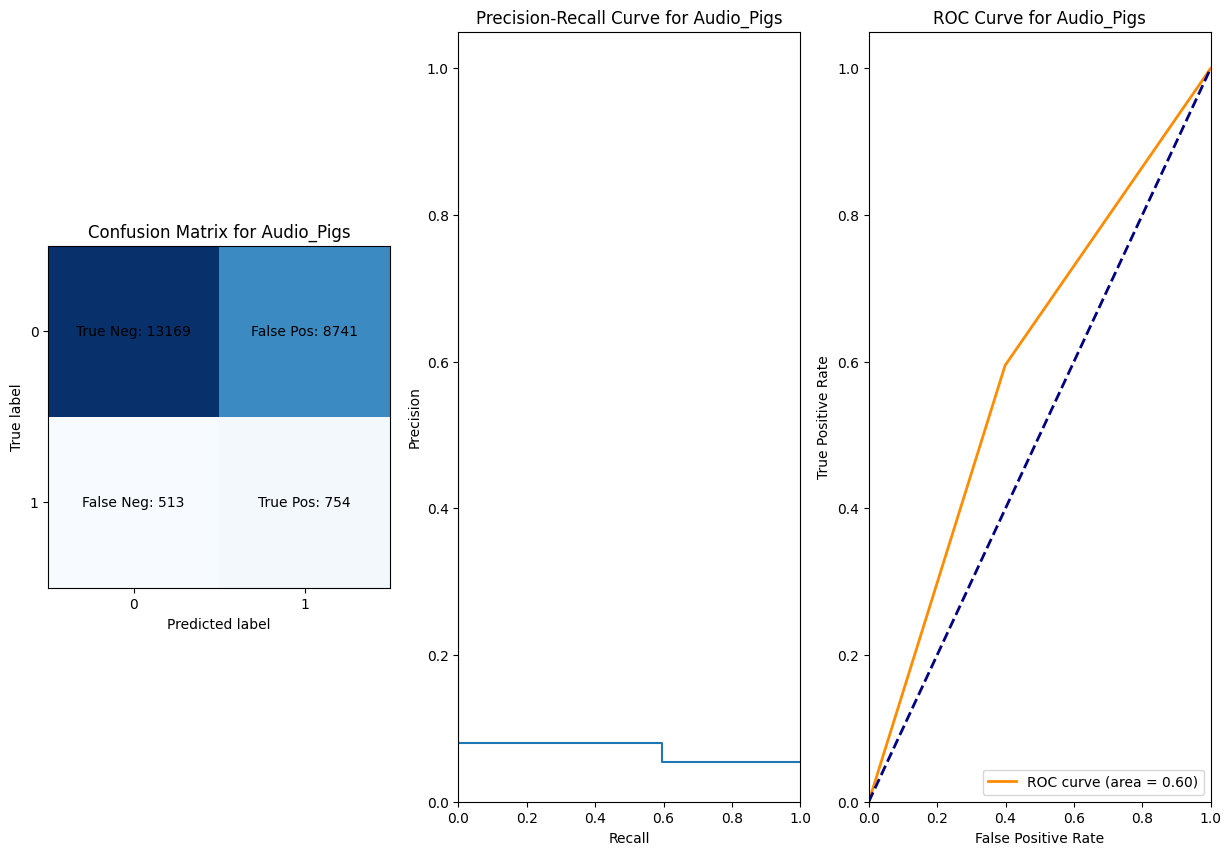

In [167]:
#evaluation metrics for pigs
#ridge classifier balanced, ssag


accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs ridge classifier, balanced, sag: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [147]:
#sus wie schnell das geht... probiere mit svm
# training model for Kermit
from sklearn.svm import SVC

svm_pigs=SVC(kernel='sigmoid')

svm_pigs.fit(X_train, y_train["Audio_Pigs"])

y_pred_pigs = svm_pigs.predict(X_test)

In [145]:
#sus wie schnell das geht... probiere mit svm
# training model for Kermit
from sklearn.svm import SVC

svm_cook=SVC(kernel='sigmoid')

svm_cook.fit(X_train, y_train["Audio_Cook"])

y_pred_cook = svm_cook.predict(X_test)

In [123]:
#cook
#
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
#max_iter=100
rc_cook = RidgeClassifier()
rc_cook.fit(X_train,y_train["Audio_Cook"])

# if rc_pigs.n_iter_ == max_iter:
#     print("Solver has reached the maximum number of iterations. Consider increasing max_iter.")
# else:
#     print("Solver has converged within the specified max_iter.")

y_pred_cook = rc_cook.predict(X_test)

Metrics for Audio_Cook Predominant Color only: 
Accuracy: 0.9799801527376278
Precision: 0.006896551724137931
Recall: 0.003115264797507788
F1 Score: 0.004291845493562232
Confusion Matrix:
[[22712   144]
 [  320     1]]


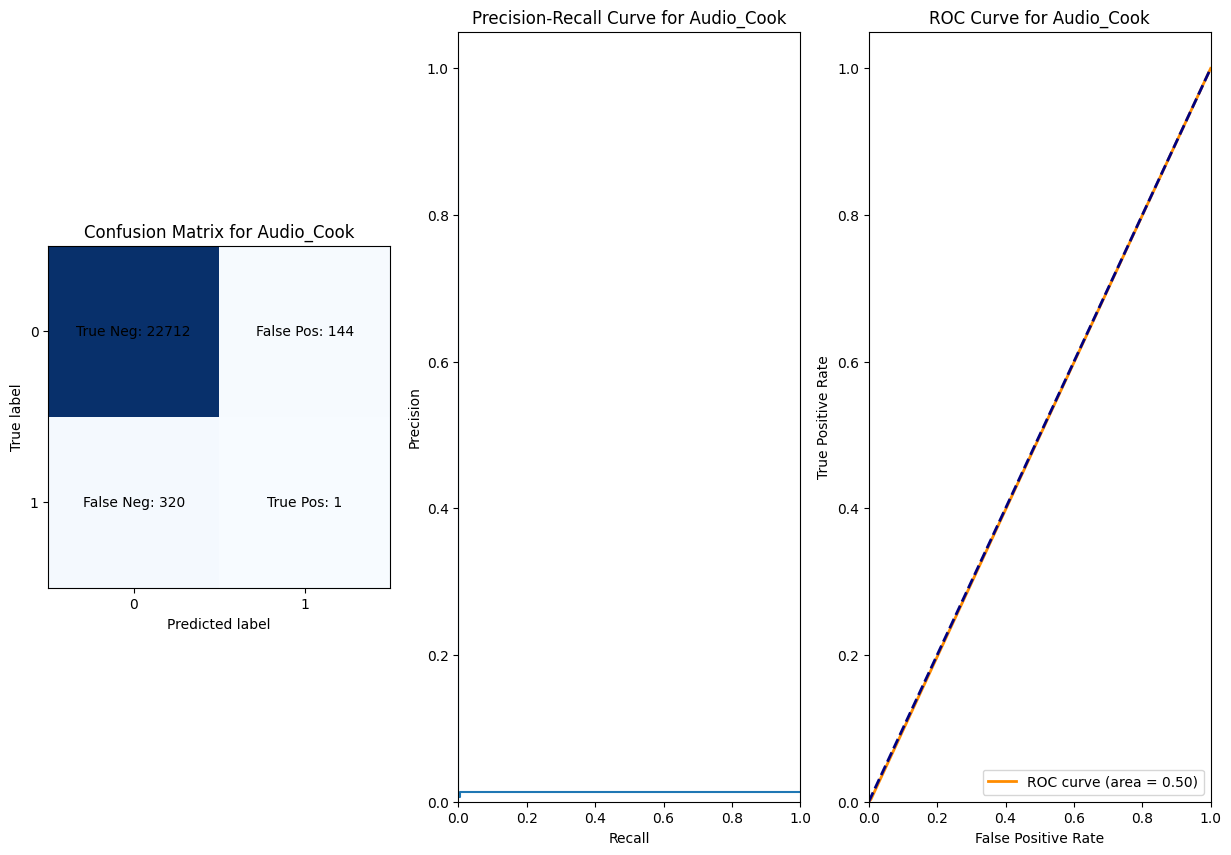

In [146]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Cook"], y_pred_cook)
precision = precision_score(y_test["Audio_Cook"], y_pred_cook)
recall = recall_score(y_test["Audio_Cook"],y_pred_cook)
f1 = f1_score(y_test["Audio_Cook"], y_pred_cook)
conf_matrix = confusion_matrix(y_test["Audio_Cook"], y_pred_cook)

# Print the metrics
print("Metrics for Audio_Cook Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Cook"], y_pred_cook, "Confusion Matrix for Audio_Cook", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Cook"], y_pred_cook, "Precision-Recall Curve for Audio_Cook", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Cook"], y_pred_cook, "ROC Curve for Audio_Cook", ax=axs[2])

Metrics for Audio_Pigs Predominant Color only: 
Accuracy: 0.9004185183587177
Precision: 0.06516290726817042
Recall: 0.06156274664561957
F1 Score: 0.06331168831168832
Confusion Matrix:
[[20791  1119]
 [ 1189    78]]


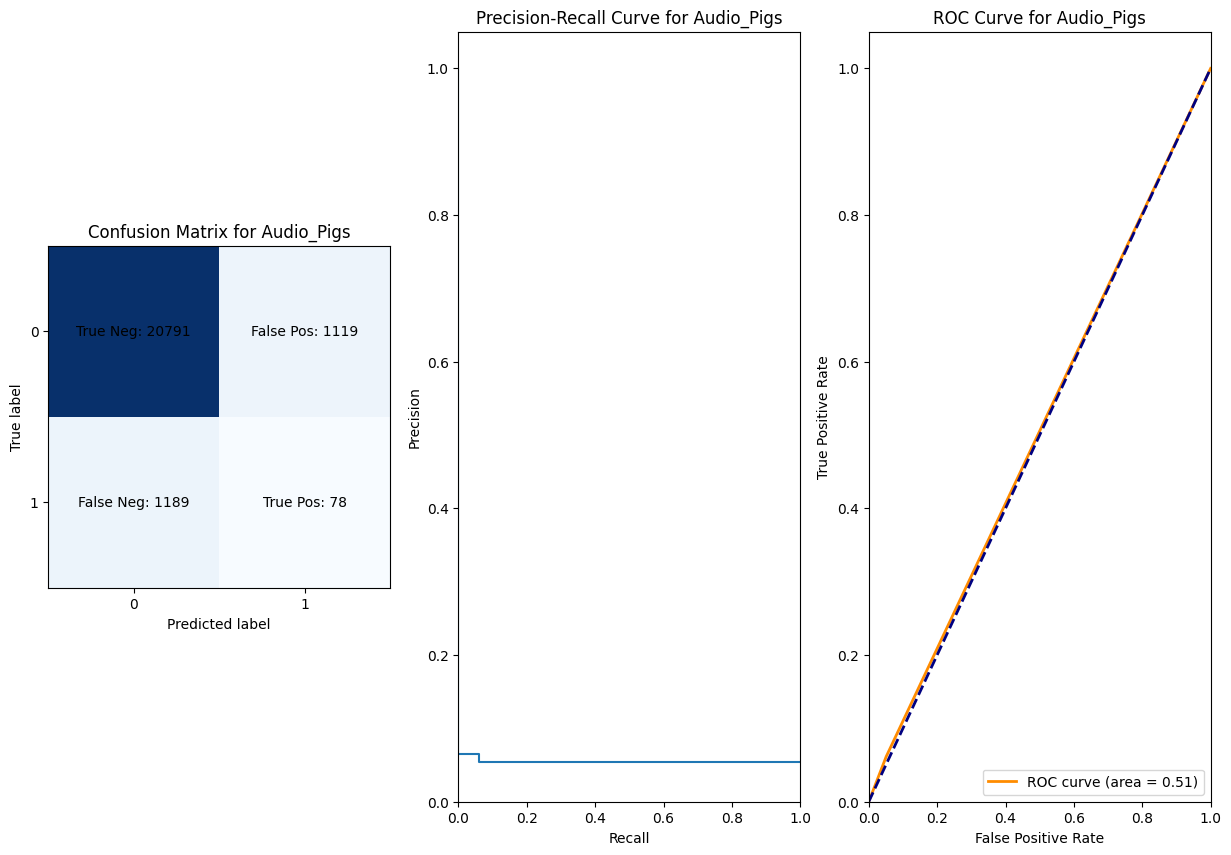

In [148]:
#evaluation metrics for pigs
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_Pigs"], y_pred_pigs)
precision = precision_score(y_test["Audio_Pigs"], y_pred_pigs)
recall = recall_score(y_test["Audio_Pigs"],y_pred_pigs)
f1 = f1_score(y_test["Audio_Pigs"], y_pred_pigs)
conf_matrix = confusion_matrix(y_test["Audio_Pigs"], y_pred_pigs)

# Print the metrics
print("Metrics for Audio_Pigs Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_Pigs"], y_pred_pigs, "Confusion Matrix for Audio_Pigs", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_Pigs"], y_pred_pigs, "Precision-Recall Curve for Audio_Pigs", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_Pigs"], y_pred_pigs, "ROC Curve for Audio_Pigs", ax=axs[2])

In [150]:
from sklearn.svm import SVC

svm_mp=SVC(kernel='sigmoid')

svm_mp.fit(X_train, y_train["Audio_MissPiggy"])

y_pred_mp = svm_cook.predict(X_test)

Metrics for Audio_MissPiggy Predominant Color only: 
Accuracy: 0.9570695085645252
Precision: 0.020689655172413793
Recall: 0.0035046728971962616
F1 Score: 0.005994005994005994
Confusion Matrix:
[[22179   142]
 [  853     3]]


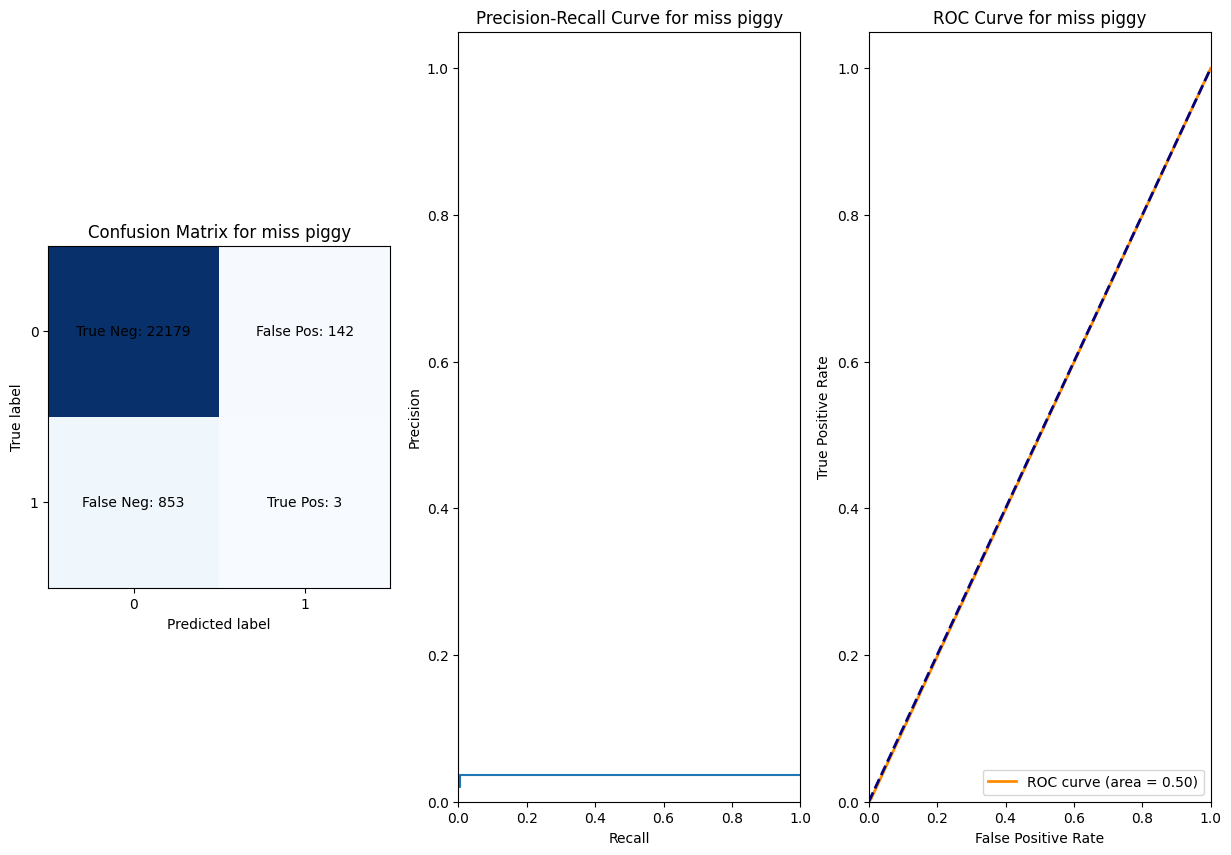

In [151]:
#evaluation metrics for mp
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Audio_MissPiggy"], y_pred_mp)
precision = precision_score(y_test["Audio_MissPiggy"], y_pred_mp)
recall = recall_score(y_test["Audio_MissPiggy"],y_pred_mp)
f1 = f1_score(y_test["Audio_MissPiggy"], y_pred_mp)
conf_matrix = confusion_matrix(y_test["Audio_MissPiggy"], y_pred_mp)

# Print the metrics
print("Metrics for Audio_MissPiggy Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Audio_MissPiggy"], y_pred_mp, "Confusion Matrix for miss piggy", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Audio_MissPiggy"], y_pred_mp, "Precision-Recall Curve for miss piggy", ax=axs[ 1]
)
plot_roc_curve(y_test["Audio_MissPiggy"], y_pred_mp, "ROC Curve for miss piggy", ax=axs[2])

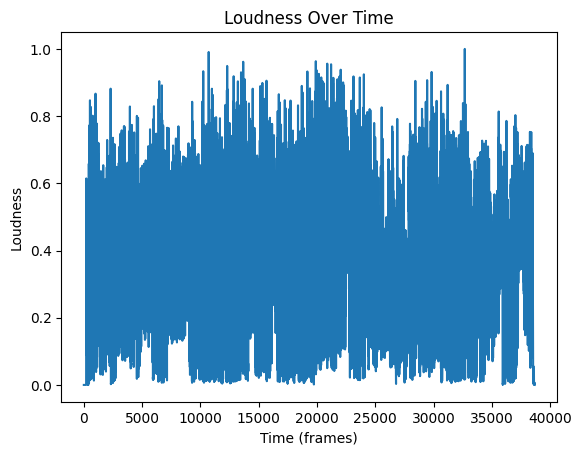

In [25]:
#feature analysis
import matplotlib.pyplot as plt
import numpy as np

# Assuming loudness is a list/array of loudness values over time
loudness = dataset.audios[0]["loudness_rms"]

# Create a time array
time = np.arange(0, len(loudness))

# Plot loudness over time
plt.plot(time, loudness)
plt.title('Loudness Over Time')
plt.xlabel('Time (frames)')
plt.ylabel('Loudness')
plt.show()


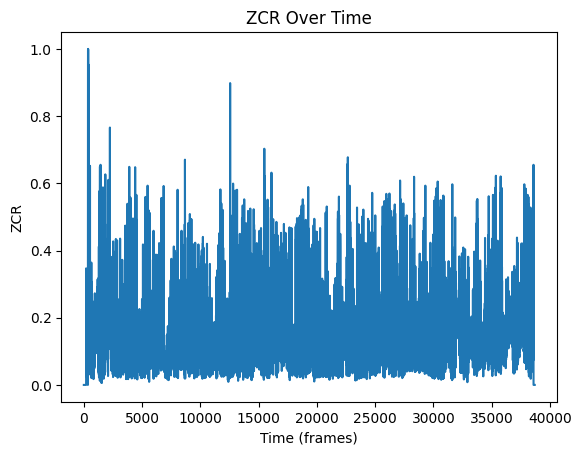

In [26]:
#feature analysis
import matplotlib.pyplot as plt
import numpy as np

# Assuming loudness is a list/array of loudness values over time
zcr = dataset.audios[1]["zcr"]

# Create a time array
time = np.arange(0, len(zcr))

# Plot loudness over time
plt.plot(time, zcr)
plt.title('ZCR Over Time')
plt.xlabel('Time (frames)')
plt.ylabel('ZCR')
plt.show()